# Using SARIMAX Modeling to Forecast NYC Rental Prices

David Richter <br>
d.richte@gmail.com <br>
August 8, 2022

## Introduction

Since the start of 2022, New York rental prices have been rising at record levels: over 25% between May 2021 and May 2022. This rate of increase is unprecedented: Since 2007, rents have rarely risen above 5% year over year and never risen above 10% year over year. It also creates a dilemma for renters who are thinking about moving or signing new leases.

# Client Question: Is it better to sign a new lease now or later?

If rental prices are likely to drop, then renters should hold out on moving and signing new leases. However, if prices are likely to rise, then renters should lock in leases sooner rather than later and might be wise to sign two-year leases if possible. If rents are expected to rise substantially over the next year, then it would benefit renters to sign longer term leases at higher price points, while an expected drop or stabilization of rents should discourage from signing longer term leases at higher price points.

## General approach: Forecasting Price Changes with SARIMAX Modeling.

Predicting whether prices will rise or fall depends on building a model that we think will predict rental prices with a low level of error. Time series are often best described by a SARIMA model, which regresses values of a series on past values of that same series. However, because rents are affected by external economics, we should be able to improve on a simple SARIMA model by including exogenous regressors as well. 

The challenge is identifying exogenous variables that we think may be leading indicators for changes in rental prices. If we can identify variables that are correlated with rental prices at a lag than we should be able to improve our model's ability to make long-term forecasts. Because SARIMA models don't include exogenous variables, their error often increases dramatically when used to make forecasts several periods ahead, but by including the right exogenous variables we may be able to bring the model's error down significantly. 


## The challenge of modeling rental prices

Because New York rental prices have risen at a relatively steady rate for most of the past fifteen years, identifying leading indicators is challenging. The four main patterns in rental prices over the past fifteen years are:

1. The rise and fall of rents during the period of the 2007-2008 financial crisis.
2. A steady rise from 2010 to 2020.
3. A fall in rents throughout 2020 as a result of COVID-19.
4. A record increase in rents beginning in the summer of 2021.

In short, 10 out of the past 15 years of rental data have a nearly constant upward slope. Our objective is to find variables that are leading indicators for the most recent dip and rise and that also might reliably predict future dips and rises. However, to establish the reliability of these leading indicators, we should also be able to confirm their predictive power during the relatively uneventful pre-COVID-19 period. In order to do this we'll divide our data set into five periods, calculate correlations with exogenous variables at a series of lags for each of these periods and use the lags that are most consistently correlated with our target as exogenous predictors in our SARIMAX model.

# Data Used for Modeling

## Target Variable: The StreetEasy Rent Index

As a target variable for modeling, I used the [StreetEasy Rent Index](https://streeteasy.com/blog/data-dashboard), which uses a [repeat-price method](https://streeteasy.com/blog/methodology-price-and-rent-indices/#_ftn2) to measure the increase in New York rents over time. The repeat-price method regresses on increases per month-to-month period based on price changes for units with multiple listings and calculates index values forward and backward relative to the Median StreetEasy listing for the year 2016. Index values are smoothed using a seasonal ARIMA model.


## Exogenous Variables

Since the 2007-2008 financial crisis and COVID-19 are one-off historical events that are either difficult or impossible to model reliably, we need to focus our attention on variables likely to effect the rental market in the short term. I start by looking at eleven variables falling into five categories:


1. Real Estate Prices
   - StreetEasy Sale Price Index NYC
   - StreetEasy Sale Price Index Manhattan
   - StreetEasy Sale Price Index Brooklyn
   - StreetEasy Sale Price Index Queens
2. Measures of the Price of Credit
   - Federal Funds Rate
   - 30 Year Mortgage Rate
3. Measures of Inflation
   - PPI (Producer Price Index) for Building and Construction Materials
   - CPI (Consumer Price Index) for Urban Consumers
4. Measures of Demand
   - Total Personal Income in New York State
   - Total Wages and Salaries in New York State
5. Measure of Supply
   - Employees in Residential Construct, New York State

Below, I discuss these exogenous variables as well as the data sources for each of them. 

### Real Estate Prices

The relationship betwen sale and rental prices is complex. On the one hand, their prices are both affected by overall supply and demand for housing. On the other had, real estate is a financial asset, so its value is more directly affected than rental prices by long-term expectations of appreciation and by the cost of borrowing.

For real estate price data, I used the [StreetEasy Price Indices](https://streeteasy.com/blog/data-dashboard). StreetEasy calculates price indices for NYC as a whole, Manhattan, Brooklyn, and Queens using the same repeat-price method that is used for the rent index--a method similar to that used to calculate the FHFA House Price Index and the Case-Shiller Home Price Index. Because Manhattan prices are most closely correlated with the New York Rental Market as a whole, I ended up using only Manhattan prices for modeling.

### Measures of the Pride of Credit

#### The federal funds rate

The federal funds rate is the interest rate charged by banks making overnight loans to each other. Because this rate can be manipulated by the Federal Reserve, it may be more effective as a leading indicator than the 30-Year mortgage rate, which is affected both by the federal funds rate as well as by the real estate market. 

However, because the federal funds rate is manipulated in response to economic conditions, it may be challenging to distinguish between the effects of rate changes and effects of the conditions that lead the Fed to increase or decrease target rates in the first place.

**Source:**
Board of Governors of the Federal Reserve System (US), Federal Funds Effective Rate [FEDFUNDS], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/FEDFUNDS, September 1, 2022.

#### Average 30-Year mortgage rate in the US

High mortgage rates are typically indicative of a robust real estate market since they reflect a high demand for borrowing. However, recent [news stories](https://www.nytimes.com/2022/07/11/business/economy/rent-inflation-interest-rates.html) have focused on the fact that because high mortgage rates are cooling the demand for home purchases, they are causing potential buyers to enter the rental market instead, which is in turn driving up rents. 

In turn, a cooler demand for home purchases is likely to bring rates down (this [recent Forbes article](https://fortune.com/2022/08/02/housing-market-correction-mortgage-rates/) suggests that currently declining rates may be pricing in a recession). This means that mortgage rates might not be a good leading indicator of housing trends so much as a mediator of exogenous factors that affect supply and demand for both credit and housing.

Mortgage rate data is from Freddie Mac and is calculated weekly. However, because StreetEasy rental data is calculated on a monthly basis, I resampled mortgage rate data by taking a monthly mean of the weekly figures.

**Source:**
Freddie Mac, 30-Year Fixed Rate Mortgage Average in the United States [MORTGAGE30US], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MORTGAGE30US, July 18, 2022.

### Measures of Inflation 

#### Cost of building materials

Since the cost of building materials makes new construction more expensive, it's likely to put upward pressure on the housing market. This seems to be a major way in which supply-chain related inflation has affected and will continue to affect the US housing market. 

**Source:**
U.S. Bureau of Labor Statistics, Producer Price Index by Industry: Building Material and Supplies Dealers [PCU44414441], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/PCU44414441, July 19, 2022.

#### Consumer Price Index

The CPI for urban consumers measures the changes in the price of the typical basket of goods purchased by an urban consumer in the US over a given period. CPI is an overall measure of how much consumers are being squeezed by inflation, which in turn affects the demand for housing.

U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average [CPIAUCSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCSL, July 25, 2022.

### Measures of Demand

#### Total Personal Income for New York State

Personal income for New York State is one measure that may influence housing demand. Personal income is a broad category that includes government benefits as well as dividends, interest and rental income. A high level of total personal income can therefore be caused by factors as various as overall population growth, COVID stimulus spending, increasing wages, and high corporate dividends.

Personal income is calculated on a quarterly basis, so values were forward-filled for the months following each quarterly report.

**Source:**
U.S. Bureau of Economic Analysis and Federal Reserve Bank of St. Louis, Total Personal Income in New York [NYOTOT], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/NYOTOT, July 25, 2022.

#### Wage and Salary Total for New York State

The wage and salary total for New York State is a much narrower measure of consumer demand than total income. Wage and salary totals exclude many sources of income such as government benefits and corporate dividends (sources of income more common for low and high income earners than for median income earners), and it's worth investigating whether the narrower fraction of income represented by this metric may be more be more correlated than total income with housing demand. While ultrawealthy New Yorkers (who derive a larger portion of their income from dividends and rents) still drive demand within the city, a larger than average proportion of the demand they generate is likely for homes and services outside of the city. On the hand, New Yorkers deriving their income from government benefits rather than salary or wages are more likely to live in federal housing projects, in rent-stabilized apartments, or with family members and therefore may also play a smaller role in driving market rents than waged or salaried employees.

Like total income, wage and salary totals are calculated on a quarterly basis, so values were forward-filled for the months following each quarterly report.

**Source:**
U.S. Bureau of Economic Analysis and Federal Reserve Bank of St. Louis, Total Wages and Salaries in New York [NYWTOT], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/NYWTOT, July 20, 2022.

### Measure of Supply

#### Number of Employees in Residential Construction, New York State

Ideally, I would have used data for the number of employees in residential construction in New York City (rather than New York State), since this would have served as a proxy for the amount of new housing being created within the city. However, data was only available for total employees in construction in New York City (including employees in non-residential construction). I chose to use state data because residential construction outside of the city would likely decrease some of the upward pressure on the city's housing market, while non-residential construction within the city would do nothing to relieve this pressure. 

In the short term, the amount of residential construction in New York actually turned out to be a leading positive indicator of rental increases rather than a negative indicator. This may be because at shorter lags, construction is anticipating demand in the rental market, but is not being completed fast enough to reduce prices in the short term.

**Source:**
U.S. Bureau of Labor Statistics and Federal Reserve Bank of St. Louis, All Employees: Construction: Residential Building Construction in New York [SMU36000002023610001SA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/SMU36000002023610001SA, July 22, 2022.

# Data Preparation

## Importing Libraries

In [1]:
# Importing libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns

import itertools

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

## Defining Functions for Importing Data

In [2]:
# Defining functions to read in FRED (Federal Reserve) and StreetEasy Data

def read_fred(filename, title):
    
    """
    Takes in a FRED csv file and returns a dataframe, with datetime values as index and column name set by user.
    """
    
    data = pd.read_csv(f'data/{filename}.csv')
    data['DATE'] = pd.to_datetime(data['DATE'], infer_datetime_format=True)
    data.set_index('DATE', inplace=True)
    data.rename(columns={filename: title}, inplace=True)
    return data

def read_se(filename, title):
    
    
    """
    Takes in csv data representing street easy index values and returns a dataframe, with datetime values as index and column
    name set by user.
    
    """
    
    data = pd.read_csv(f'data/{filename}.csv')
    data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format=True)
    data.set_index('Month', inplace=True)
    data.rename(lambda x: f'{x} {title} Index', axis=1, inplace=True)
    return data

## Importing and Resampling Data

All data is resampled on a monthly basis. In the case of weekly Mortgage Rate data, the monthly mean is taken. In the case of Salary and Income data values are forward filled. 

In [3]:
# Reading in FRED and StreetEasy Data

building_materials_ppi = read_fred('PCU44414441', 'Building Materials')
cpi = read_fred('CPIAUCSL', 'CPI')
fed_funds = read_fred('FEDFUNDS', 'Federal Funds Rate')
mortgage_30 = read_fred('MORTGAGE30US', '30 Year Mortgage Rate').resample('MS').mean()
construction_employees = read_fred('SMU36000002023610001SA', 'Employees in Construction')
wage_salary = read_fred('NYWTOT', 'Wages and Salaries').resample('MS').ffill()
personal_income = read_fred('NYOTOT', 'Personal Income').resample('MS').ffill()


sale_data = read_se('priceIndex_All', 'Sale Price')
rental_data = read_se('rentalIndex_All', 'Rental')['NYC Rental Index']

## Inspecting Target

In [4]:
# Inspecting first and last dates of rental data

rental_data

Month
2007-01-01    2204.0
2007-02-01    2160.0
2007-03-01    2177.0
2007-04-01    2191.0
2007-05-01    2216.0
               ...  
2022-01-01    2972.0
2022-02-01    3020.0
2022-03-01    3069.0
2022-04-01    3123.0
2022-05-01    3185.0
Name: NYC Rental Index, Length: 185, dtype: float64

While the StreetEasy Rental Index only includes data from January 2007 to May 2022, we'll combine this with all data from the other datasets, since we'll be using lags from earlier dates as exogenous variables in our models.

## Combining All Data in a Single Dataframe

In [5]:
# Combining all time series in a single dataframe

all_data = pd.concat([rental_data, fed_funds, mortgage_30, building_materials_ppi, cpi, construction_employees, wage_salary, personal_income, sale_data], axis=1)

In [6]:
# Inspecting End of Dataset for missing values

all_data['2022-01-01':]

,NYC Rental Index,Federal Funds Rate,30 Year Mortgage Rate,Building Materials,CPI,Employees in Construction,Wages and Salaries,Personal Income,Brooklyn Sale Price Index,Manhattan Sale Price Index,NYC Sale Price Index,Queens Sale Price Index
2022-01-01,2972.0,0.08,3.4450,217.684,281.933,59.813755,853004160.0,1514628.1,679811.0,1071336.0,610655.0,512987.0
2022-02-01,3020.0,0.08,3.7625,235.392,284.182,59.994384,NaN,NaN,681075.0,1077736.0,612430.0,515539.0
2022-03-01,3069.0,0.20,4.1720,257.346,287.708,60.764042,NaN,NaN,684634.0,1079077.0,613987.0,517645.0
2022-04-01,3123.0,0.33,4.9825,251.519,288.663,61.356176,NaN,NaN,685194.0,1086098.0,615798.0,519417.0
2022-05-01,3185.0,0.77,5.2300,242.485,291.474,61.498591,NaN,NaN,696957.0,1097375.0,618374.0,517036.0
2022-06-01,NaN,1.21,5.5220,233.562,295.328,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-01,NaN,1.68,5.4050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Forward Filling Empty Wage and Salary and Personal Income Values, since this is the only time series
# that doesn't have values through 2022-05-01, the end of the rental data series.
for column in ['Wages and Salaries', 'Personal Income']:
    all_data[column] = all_data[column].ffill()

In addition to including values for earlier dates than our rental values, we also need to include later empty date rows in our dataframe, since we don't want to lose lagged data that we'll need to use to make predictions for future dates.

In [8]:
# Adding additional empty rows so that lagged data is retained.

index = pd.date_range(pd.to_datetime('2022-08-01'), periods=12, freq='MS')
 
columns = list(all_data.columns)
 
next_twelve_months = pd.DataFrame(index=index, columns=columns)

all_data = pd.concat([all_data, next_twelve_months], axis=0)

## EDA Target Variable

Before looking at exogenous variables we'll first look at some features of our target variable: The StreetEasy Rental Index.

In [9]:
all_data['NYC Rental Index'].describe()

count     185.000000
mean     2559.497297
std       261.622573
min      2119.000000
25%      2340.000000
50%      2572.000000
75%      2775.000000
max      3185.000000
Name: NYC Rental Index, dtype: float64

From the chart below, we can see that NYC rents reached their record level in May 2022: $3185/month as measured by the StreetEasy Rental Index.

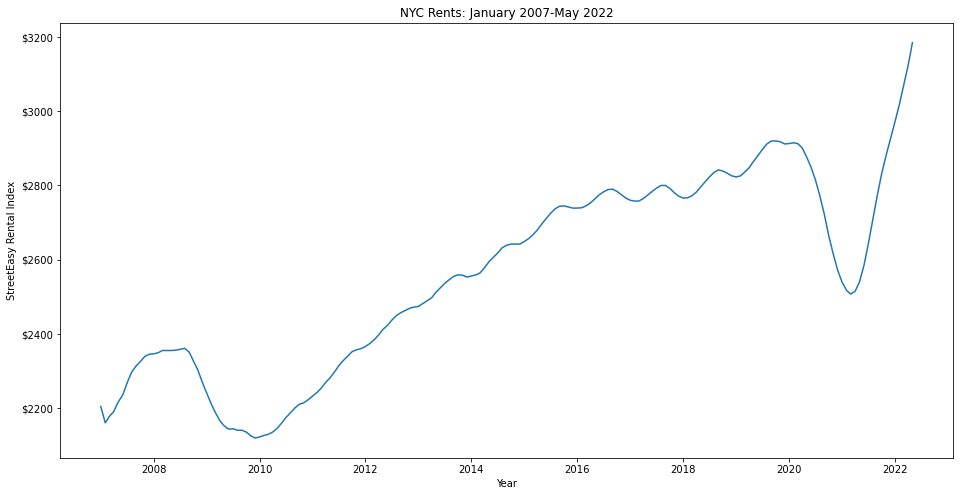

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(all_data['NYC Rental Index'])
ax.set_title('NYC Rents: January 2007-May 2022')

ax.set_xlabel('Year')
ax.set_ylabel('StreetEasy Rental Index')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)
plt.savefig('images/rental_index.png')
plt.show()

Since this series is clearly not stationary, we'll take the first difference of the series below.

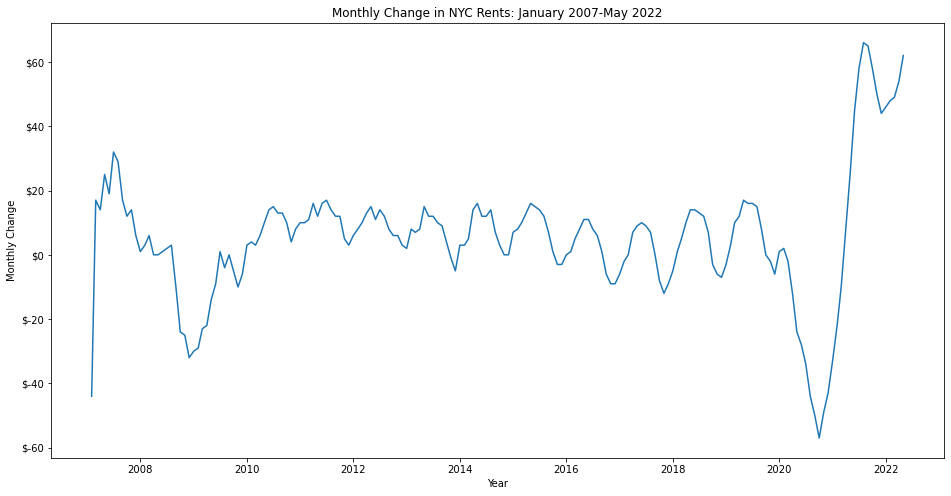

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(all_data['NYC Rental Index'].diff())
ax.set_title('Monthly Change in NYC Rents: January 2007-May 2022')

ax.set_xlabel('Year')
ax.set_ylabel('Monthly Change')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)
plt.savefig('images/monthly_change.png')
plt.show()

The first difference of our series seasonal consistent seasonal fluctuations, with rents highest during the summer months and lowest during the winter months. If we were just looking at rents between 2010 and 2020, a seasonal ARIMA model would probably be enough to make accurate predictions. However, the high variability between 2008 and 2010 and between 2020 and 2022 indicates that there are exogenous factors affecting rental prices as well.

## EDA: Comparing Target Variable to Exogenous Variables

In the EDA phase of our analysis, we'll look at three types of relationships:
1. Correlations between our target and each of the exogenous variables.
2. Correlations between our target and lags of each of the exogenous variables.
3. Correlations between the first difference of our target and the first differences of each of the exogenous variables.

While it's important to get a sense of the correlations between undifferenced target and undifferenced, lagged predictors, these relationships are ultimately not as important as the relationship between the differenced target and differenced predictors. This is because our data is not stationary. Since a first-differenced SARIMA model will be needed to stationarize the target, we will also need to stationarize our predictors through first-differencing in order to if we want them to contribute information to our model. We'll therefore be looking not at correlations between undifferenced target and predictors but between first differenced target and predictors.

### Smoothing Exogenous Variables

Since rental prices are more likely to reflect trends in exogenous variables than short term variability, I'm smoothing all of my exogenous variables by recalculating them as a 3 month rolling mean.

In [12]:
for column in list(all_data.drop(['NYC Rental Index', 'Brooklyn Sale Price Index', 'NYC Sale Price Index', 'Queens Sale Price Index'], axis=1).columns):
    all_data[column] = all_data[column].rolling(3).mean()

### Splitting Data into Two Periods: 2007-2019 and 2019-2022

To better understand the relationship between target variable and potential predictors, I plotted the relationship betwen predictors and target from January 2007 - May 2022, as well as the relationship between predictors and target in the more recent period between May 2019 and May 2022.

Ideally we want to find a model that performs well on both periods. This means that our lagged exogenous variables should be able to predict the price fluctuations of the 2007-2010 recession and recovery period as well as the stable price rises that followed it and the more recent COVID-19 era fluctuations.

In [13]:
# splitting off data with target ('Rental Index') values

rental_data = all_data['2007-01-01':'2022-05-01']

# splitting the data with targets into a training and testing set

train = rental_data.iloc[:int(0.8*len(rental_data))]
test=rental_data.iloc[int(0.8*len(rental_data)):]

### Correlations at 0 Lags 2007-2019

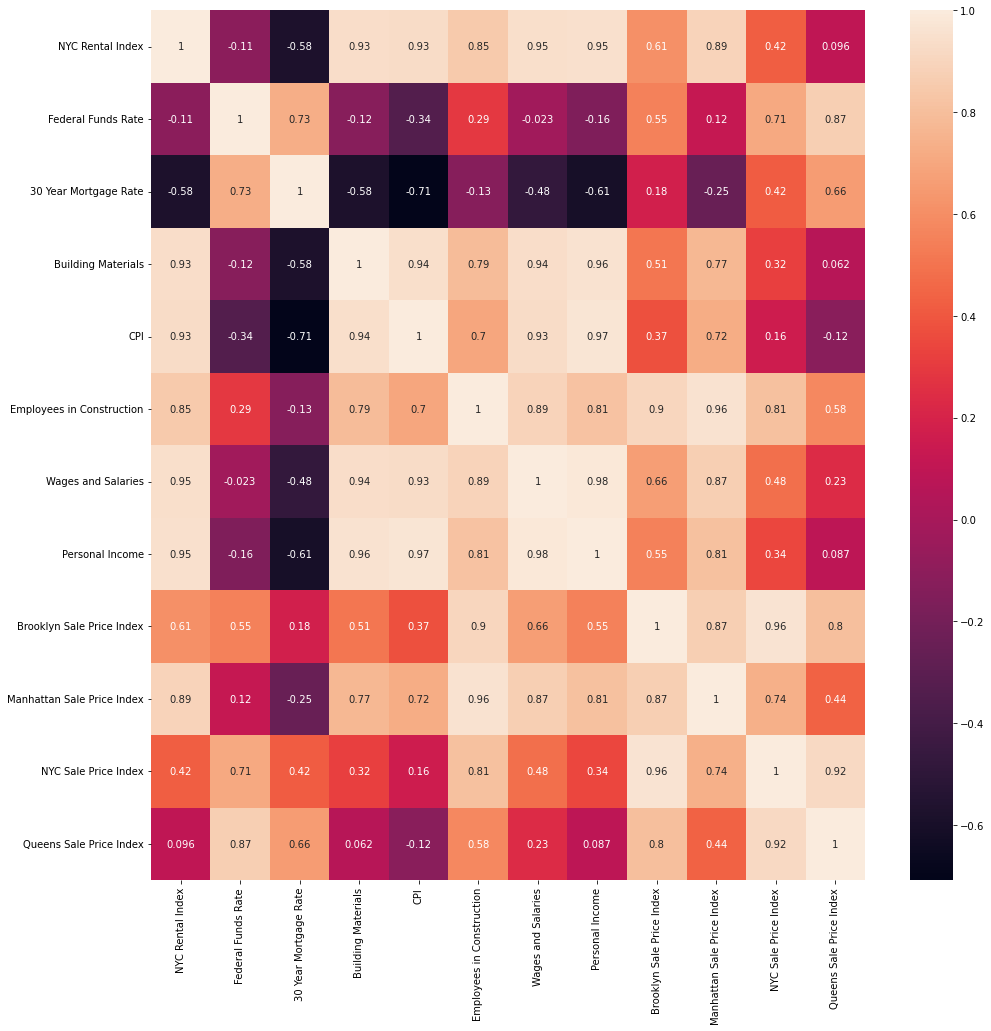

In [14]:
# Inspecting Correlations for first 80% of data set
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True, ax=ax)
plt.show()

### Correlations at 0 Lags: 2019-2022

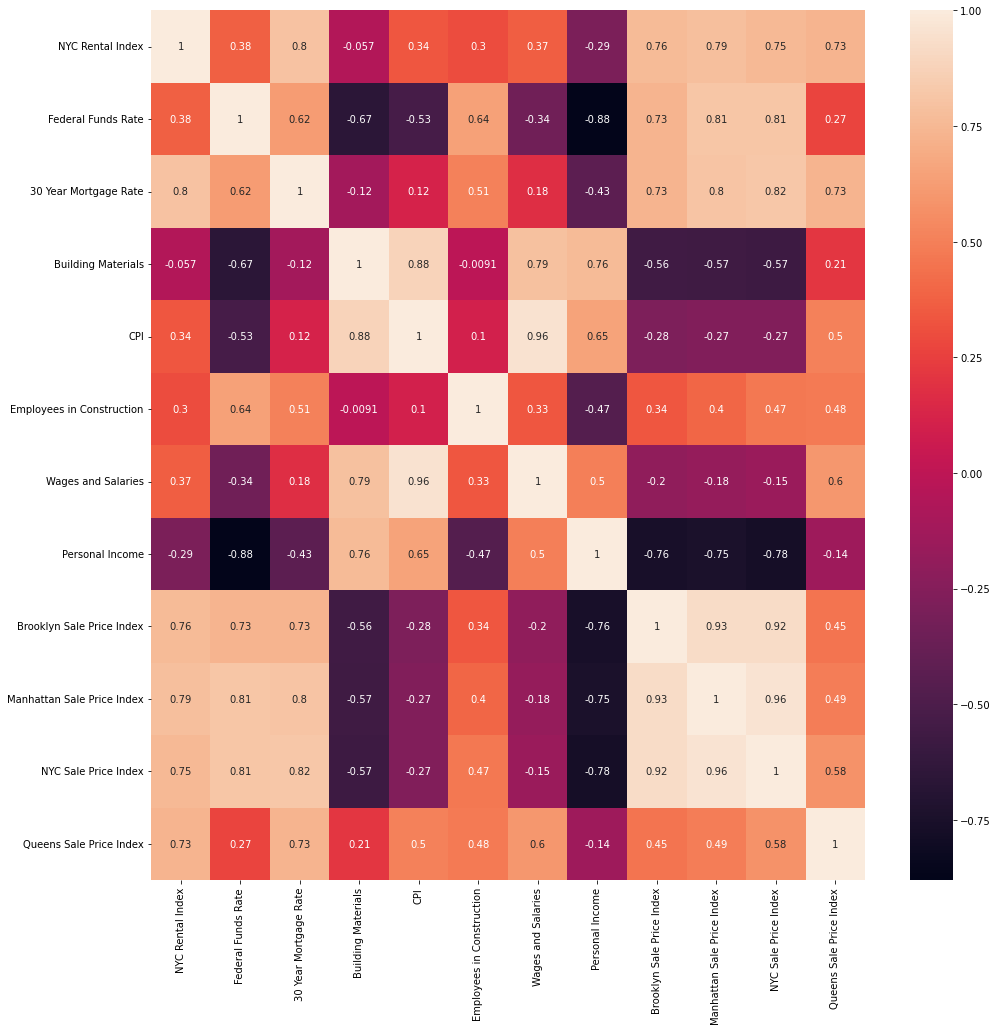

In [15]:
# Inspecting correlations for end of data set
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(test.corr(), annot=True, ax = ax)
plt.show()

At zero lags a number of variables show high (>0.75) correlations with the rental index for the first four fifths of the data set (the pre-Covid period):
- Building Materials PPI
- CPI
- Employees in Construction
- Wage and Salary Total
- Personal Income
- Manhattan Sale Prices

For the last fifth of the data set (2019-2022), the variables most highly correlated (>0.75) with the NYC Rental Index are:
- 30 Year Mortgage Rate
- Sale Prices - Brooklyn, Manhattan, NYC
- Monthly Mortgage Payments - all locations

This is to be expected. As we'll see below, during the recovery decade (2010-2020), trends for most variables remained relatively steady, whereas the COVID period has seen greater variability. In a more stable economy, the rate at which a dramatic change in one variable can affect another variable is not apparent since most variables are simply moving in steady tandem over the long term.

### Comparing Trends: Exogenous Variables Compared with Target

Below we look at how each of our exogenous variables has changed relative to its January 2007 value and compare changes in these exogenous variables with changes in our target variable.

In [16]:
rcParams['figure.figsize'] = 16, 8

def plot_trend(feature, start_date='2007-01-01', lw=1):
    
    """
    Plots trend line for feature with start date value set at 100.
    """
    
    plt.plot(100*all_data[feature][start_date:]/all_data[feature][start_date],
             label=feature,
            lw=lw)
    
def plot_target(target='NYC Rental Index', start_date='2007-01-01'):
    
    
    """
    Plots trend line for target with start date value set at 100.
    """
    
    plot_trend(target, start_date=start_date, lw=3)
    plt.title(f'Start Date: {start_date}')
    plt.axhline(y=100, ls='--')
    plt.legend()
    plt.show()
    

#### Real Estate Trends

In [17]:
all_data['2007-01-01':].head()

,NYC Rental Index,Federal Funds Rate,30 Year Mortgage Rate,Building Materials,CPI,Employees in Construction,Wages and Salaries,Personal Income,Brooklyn Sale Price Index,Manhattan Sale Price Index,NYC Sale Price Index,Queens Sale Price Index
2007-01-01,2204.0,5.246667,6.197500,118.900000,202.845667,49.669794,5.083091e+08,878565.966667,708225.0,960775.666667,647843.0,557833.0
2007-02-01,2160.0,5.250000,6.212500,120.166667,203.587667,49.891187,5.207261e+08,891984.333333,697435.0,954930.666667,641566.0,557507.0
2007-03-01,2177.0,5.256667,6.219500,120.600000,204.317000,50.082869,5.331430e+08,905402.700000,693208.0,947675.000000,635761.0,553410.0
2007-04-01,2191.0,5.256667,6.207000,121.133333,205.139333,50.280017,5.273171e+08,903665.500000,694074.0,946986.666667,638237.0,551249.0
2007-05-01,2216.0,5.253333,6.199333,122.333333,205.982333,50.677423,5.214911e+08,901928.300000,690397.0,953650.666667,638564.0,545212.0


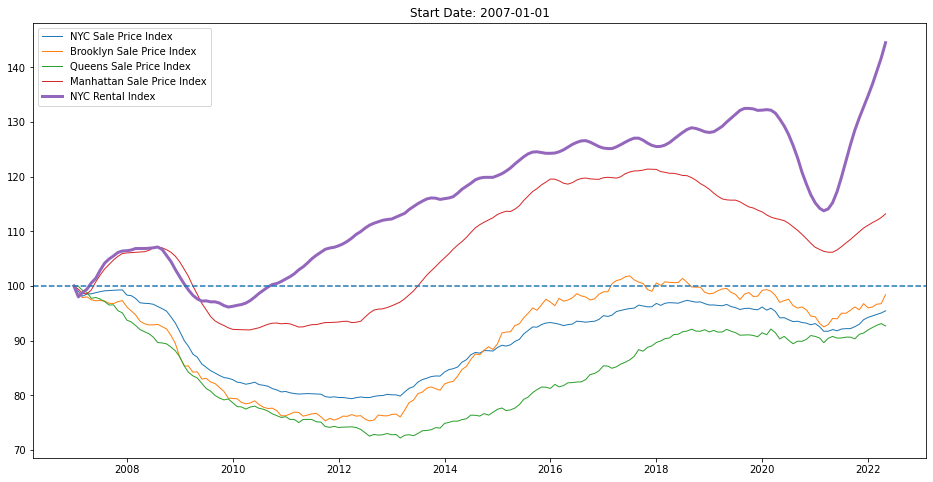

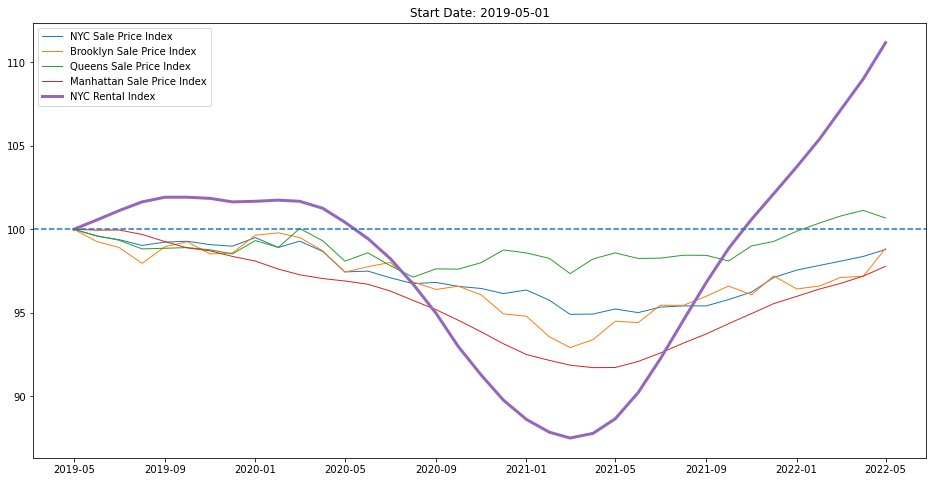

In [18]:
areas = ['NYC', 'Brooklyn', 'Queens', 'Manhattan']

start_dates = ['2007-01-01', '2019-05-01']

for start_date in start_dates:

    for area in areas:
        feature = f'{area} Sale Price Index'
        plot_trend(feature, start_date)

    plot_target(start_date=start_date)

During the 2007-2008 financial crisis the value of most homes in New York dropped significantly, while rental prices only dropped briefly in 2009 before rising steadily beginning in 2010.

In most parts of the city home prices only briefly regained their 2007 highs in 2017 and 2018. In Manhattan, on the other hand, home prices, like rent prices have stayed consistently above their 2007 values, though home prices did see a downturn as early as 2018, two years prior to COVID-19.

Manhattan home prices, like New York rents in general, were remarkably resilient during the financial crisis, falling less than home prices in Brooklyn and Queens.

#### Wage and Price Trends

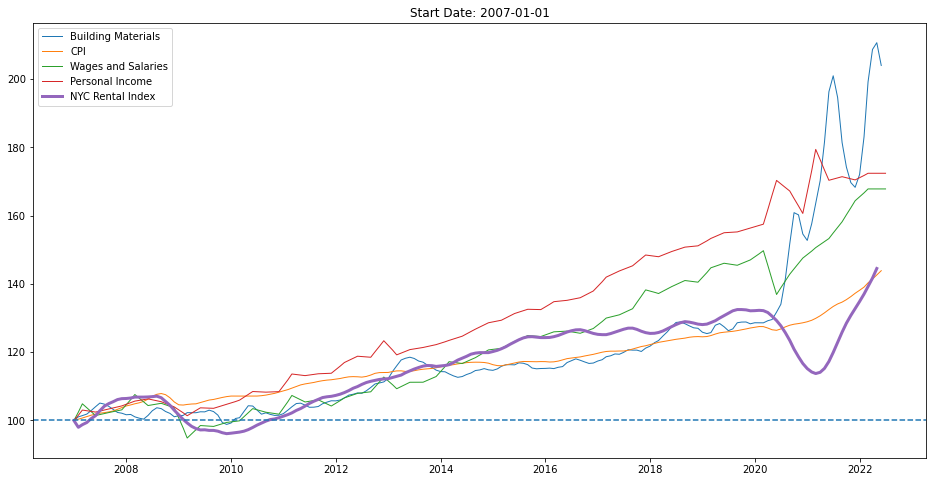

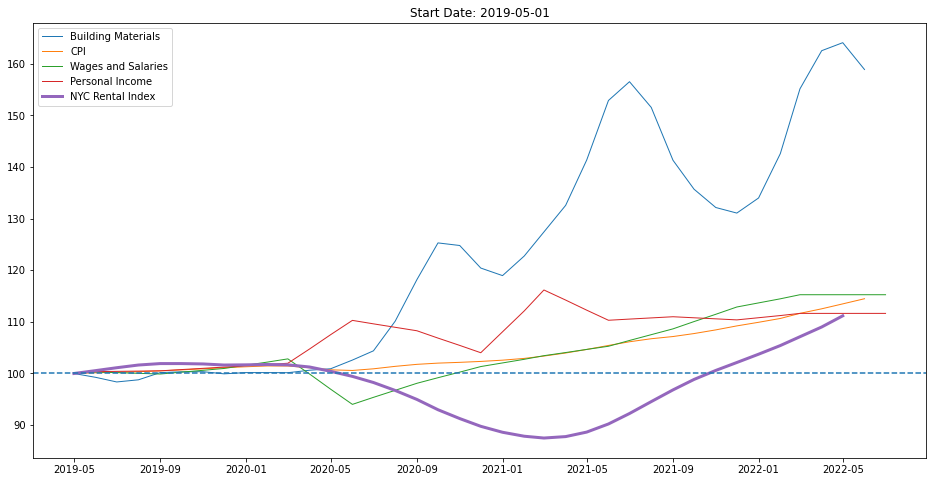

In [19]:
for start_date in start_dates:

    for feature in ['Building Materials', 'CPI', 'Wages and Salaries', 'Personal Income']:
        plot_trend(feature, start_date)
    plot_target(start_date=start_date)

In general, rental prices are have been highly correlated with other wage and price trends. 

It should be noted that the high growth in personal income and wage and salary totals does not correspond to high growth in income per household, but to New York's aggregate income, wage and salary growth. These numbers measure the size of the consumer sector as a whole rather than the buying power of individual consumers.

For much of this period total income and wages and salaries rose in tandem with rents, indicating a balance of supply and demand. However, rental price growth began slowing in 2016, while wages, salaries and income continued to grow at the same higher rate. 

Wages and Salaries dropped at the beginning of the pandemic, but pandemic stimulus spending led to an overall rise in incomes. Since then, income, wages and salaries, and the price of building materials have all increased dramatically--making all of these factors potential culprits in the recent rise in rental prices.

#### Construction Trend

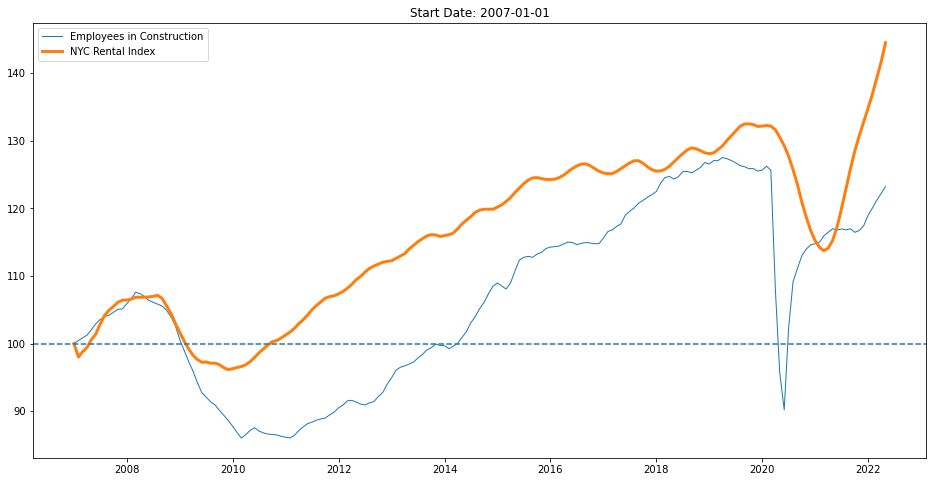

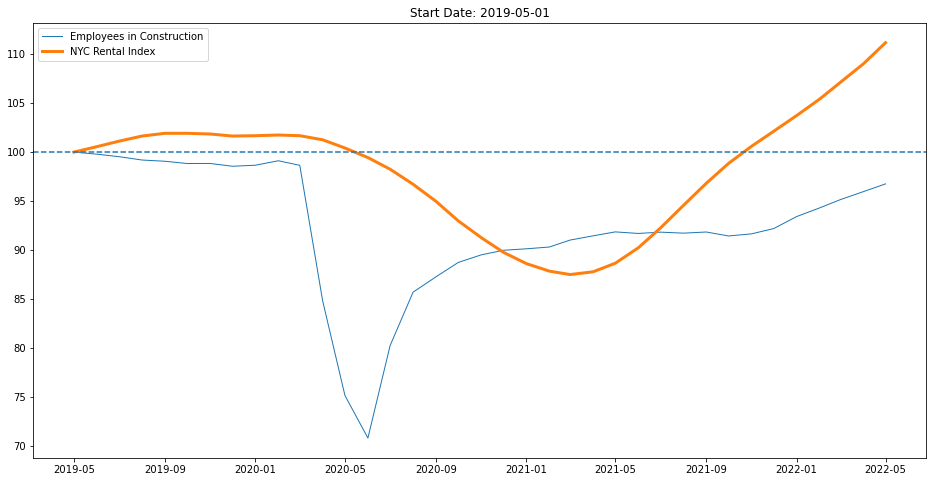

In [20]:
for start_date in start_dates:

    plot_trend('Employees in Construction', start_date)
    plot_target(start_date=start_date)

At zero lags, employment in construction is generally correlated with rental prices and the early dramatic drop in construction employees makes it a promising leading indicator for the rental market.

One would expect in the long run that fewer employees in construction would yield less construction and higher prices. Thus the 2020 dip in construction might be correlated with the 2022 rise in prices. The difficulty is that if there isn't a significant negative correlation at 24 months during the training period as well as during the testing period, then this association, no matter how persuasive, won't have the statistical significance that we need if we want to incorporate it into our model.

#### Interest Rate Trends

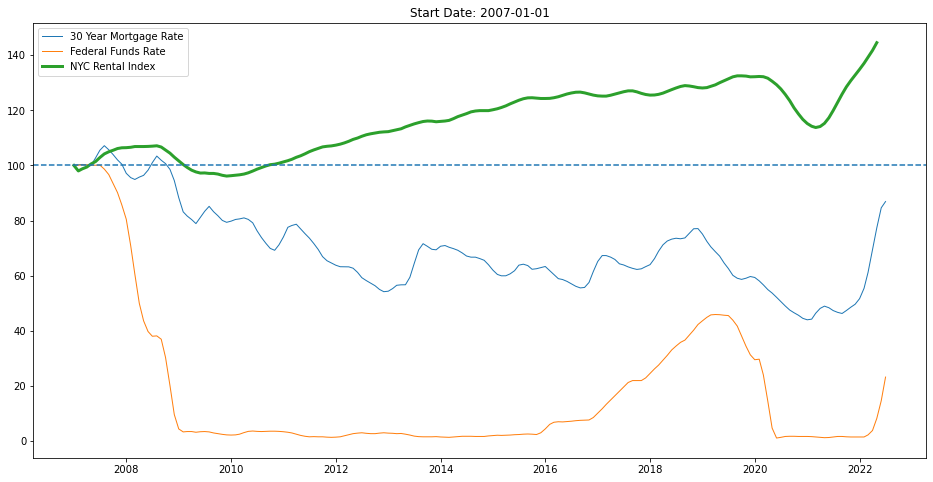

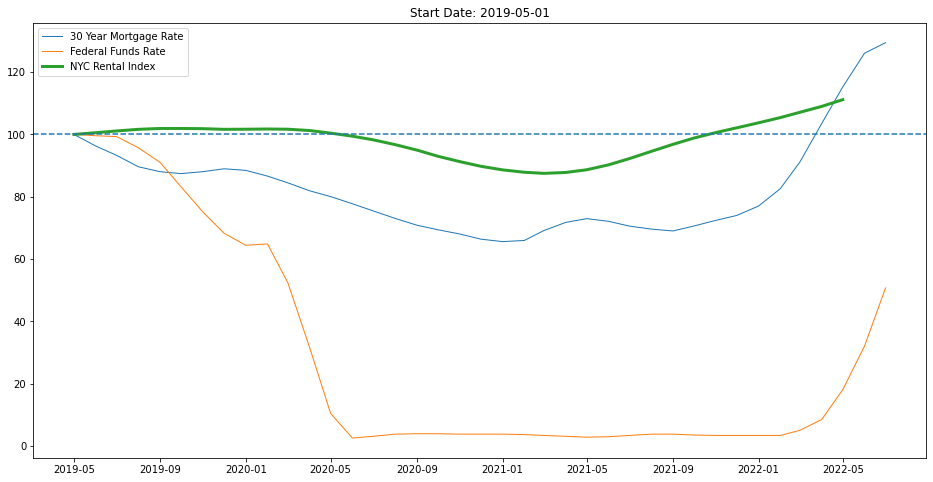

In [21]:
for start_date in start_dates:

    for feature in ['30 Year Mortgage Rate', 'Federal Funds Rate']:
        plot_trend(feature, start_date)
    plot_target(start_date=start_date)

Arguments for Fed Interest rate hikes suggest that high interest rates are needed to bring down inflation. From these charts, it's hard to discern a significant relationship between interest rates and rental prices, however. Until recently the cost of borrowing (both short and long term) has been low compared to its 2007 levels, and its too early to know whether the current high short term and mortgage rates will have any effect in bringing down prices.

## EDA: Comparing Lagged First Differences of Exogenous Variables with First Difference of Target

Below we look at the correlations between the first difference of our target variable and first difference exogenous variabesl from 0 to 24 lags. By looking at correlations with lagged variables, we'll be able to determine if exogenous variables are not merely correlated with our target, but leading indicators for our target, allowing us to use these variables to to make forecasts many months in advance.

### Ranking Correlations with Bootstrapped Confidence Intervals

In order to find the most robusts correlations between regressors and target, I divide the data set into five periods and calculated correlation for lags between 0 and 24 for each of those periods. I then bootstrap 97.5% and 2.5% confidence intervals for each of these correlations in order to rank them from highest to lowest.

In [22]:
data_diff = all_data.diff()

In [23]:
# Initialize empty lists for dataframes containing correlations for each subset and date ranges for each subset.
corr_df_list_diff = []
dates_list = []


subset_length = len(rental_data)/5
# cycle through each subset of data
for i in range(5):

    #find start and end indices for subset
    start_index = int(i*subset_length)
    end_index = int((i+1)*subset_length)
    
    corr_list_subset = []
    
    
    #cycle through each variable
    for variable in list(all_data.columns):
        
        #cycle through each lag
        for lag in range(25):
            
            # generate given lag for given exogenous variable
            exog = data_diff[variable].shift(periods=lag)
            
            #subset exogenous lag to given date range
            exog_set = exog['2007-01-01':'2022-05-01']
            exog_subset = exog_set.iloc[start_index:end_index]
            
            #subset endogenous variable to given date range
            endog = data_diff['NYC Rental Index']
            endog_set = endog['2007-01-01':'2022-05-01']
            endog_subset = endog_set.iloc[start_index:end_index]
            
            # create data frame with target variable and exogenous lag for given date range
            df_temp=pd.concat([endog_subset, exog_subset], axis=1)
            
            # calculate correlation between target variable and exogenous lag and append to correlation list
            corr_list_subset.append([variable, lag, df_temp.corr().iloc[0, 1]])
    
    #append date range to dates list before cycling to next date range
    dates_list.append([df_temp.index[0], df_temp.index[-1]]) 
    
    #make list of correlations for date subset into a dataframe 
    corr_df_list_diff.append(pd.DataFrame(corr_list_subset, columns=['variable', 'lag', 'corr']))

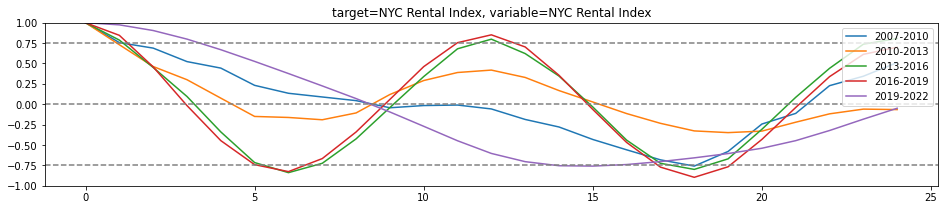

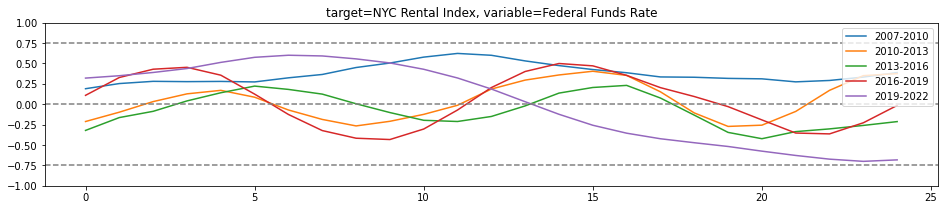

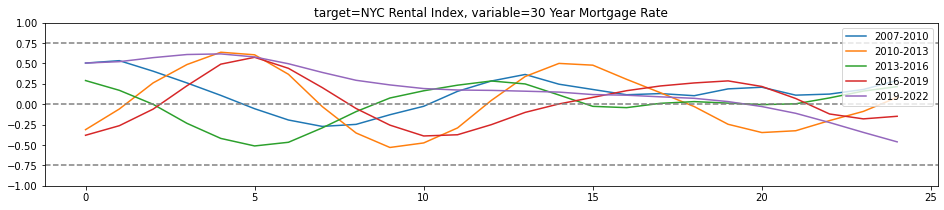

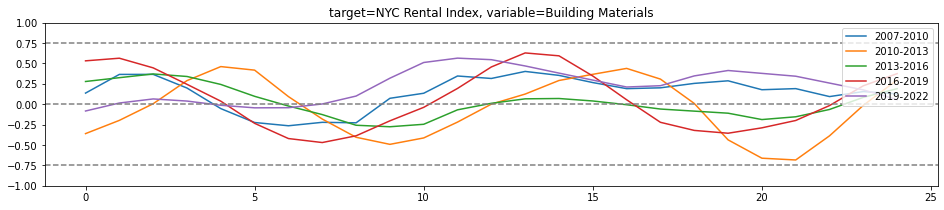

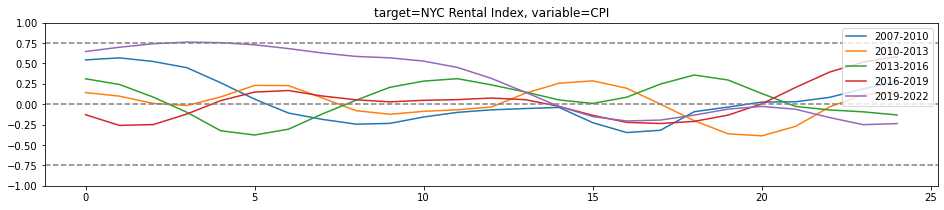

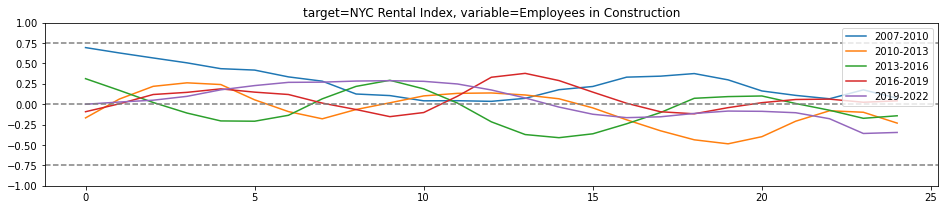

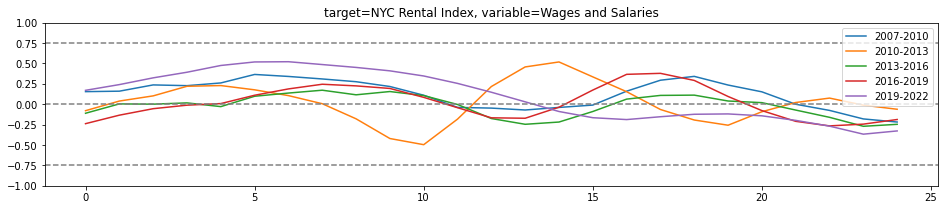

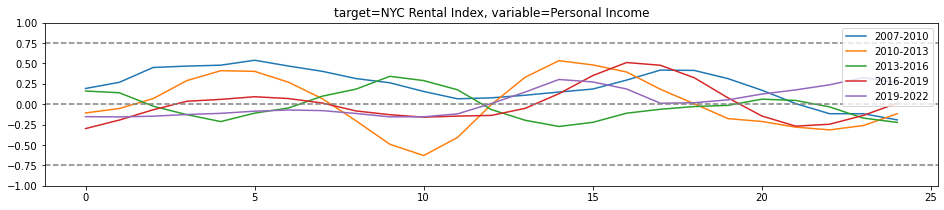

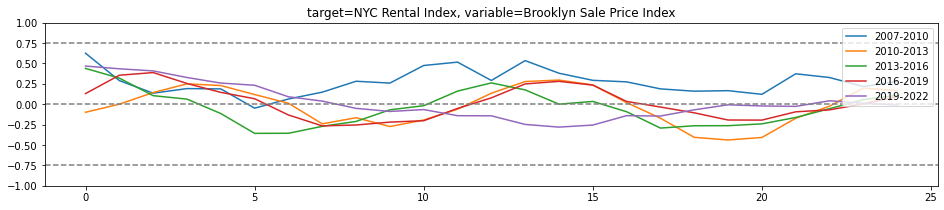

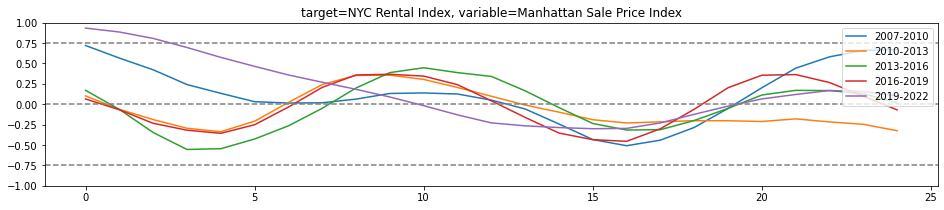

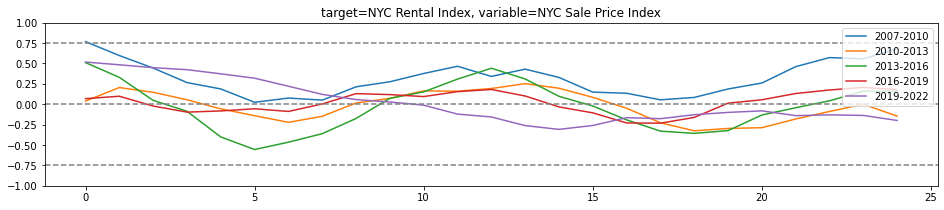

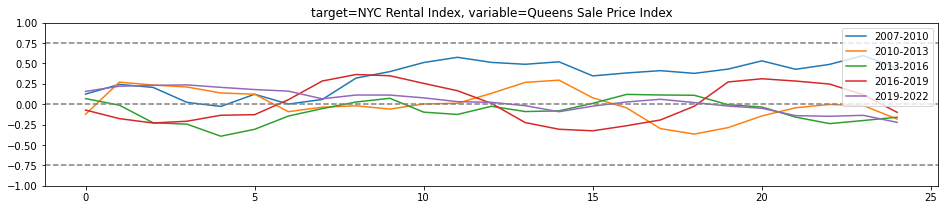

In [24]:
rcParams['figure.figsize'] = 16, 3

# Make series of plots for each variable, comparing correlations for each date subset.

# cycle through variables
for variable in list(all_data.columns):
    #cycle through subsets
    for i in range(len(corr_df_list_diff)):
        
            #pulls out each date subset for the given variable
            subset = corr_df_list_diff[i][corr_df_list_diff[i]['variable']==variable]
            
            # determines start and end dates for subset 
            start_date = str(dates_list[i][0])[:4]
            end_date = str(dates_list[i][1])[:4]
            
            # plots correlations for each date subset with labeled with appropriate dates
            plt.plot(subset['lag'], subset['corr'], label=f'{start_date}-{end_date}')
    
    
    plt.title(f'target=NYC Rental Index, variable={variable}')
    plt.axhline(y=0.75, color='gray', ls='--')
    plt.axhline(y=0, color='gray', ls='--')
    plt.axhline(y=-0.75, color='gray', ls='--')
    
    plt.ylim([-1, 1])
    plt.legend(loc='upper right')
    plt.show()

In [25]:
correlation_list = []
np.random.seed(42)
for variable in all_data.columns:
    for lag in range(25):
        correlations=np.array([float(corr_df_list_diff[i].loc\
                      [(corr_df_list_diff[i]['variable']==variable) & (corr_df_list_diff[i]['lag']==lag)]\
                      ['corr']) for i in range(5)])
        
        bootstrap_means = np.zeros([100, correlations.shape[-1]])
        for ii in range(100):
            random_sample = resample(correlations)
            bootstrap_means[ii] = random_sample.mean(axis=0)
        percentiles = np.percentile(bootstrap_means, [2.5, 97.5], axis=0)
        correlation_list.append([variable, lag, percentiles[0][0], percentiles[1][0]])

In [26]:
correlation_conf_df_diff = pd.DataFrame(correlation_list, columns=['variable', 'lag', '2.5%', '97.5%'])

In [27]:
correlation_conf_df_diff.sort_values(by='2.5%', ascending=False).head(30)

,variable,lag,2.5%,97.5%
0,NYC Rental Index,0,1.000000,1.000000
1,NYC Rental Index,1,0.756588,0.916917
2,NYC Rental Index,2,0.457468,0.771771
89,Building Materials,14,0.202004,0.458608
29,Federal Funds Rate,4,0.190085,0.427839
251,NYC Sale Price Index,1,0.187331,0.510321
88,Building Materials,13,0.169647,0.495056
90,Building Materials,15,0.166908,0.346923
234,Manhattan Sale Price Index,9,0.148588,0.370728
250,NYC Sale Price Index,0,0.146705,0.625313


In [28]:
correlation_conf_df_diff.sort_values(by='97.5%').head(20)

,variable,lag,2.5%,97.5%
18,NYC Rental Index,18,-0.819946,-0.516748
19,NYC Rental Index,19,-0.691048,-0.499130
17,NYC Rental Index,17,-0.739681,-0.336295
20,NYC Rental Index,20,-0.486454,-0.302014
241,Manhattan Sale Price Index,16,-0.456093,-0.279902
16,NYC Rental Index,16,-0.628786,-0.273838
240,Manhattan Sale Price Index,15,-0.393857,-0.249942
242,Manhattan Sale Price Index,17,-0.367067,-0.234553
174,Wages and Salaries,24,-0.261652,-0.129626
173,Wages and Salaries,23,-0.304215,-0.111896


### Exogenous Variables to Lag

For modeling, I chose the lags with the highest positive 2.5% lower confidence interval and with the lowest negative 97.5% upper confidence interval:

- Manhattan Sale Price Index 9 Month Lag
- Manhattan Sale Price Index 16 Month Lag
- Federal Funds Rate 4 Month Lag
- Wages and Salaries 6 Month Lag
- Building Materials 14 Month Lag

In the case of Manhattan Sale prices, I chose both a positive correlation at a 9 month lag as well as a negative correlation ata 16 month lag.

In [29]:
# columns for lags on exogenous variables based on bootstrapped confidence intervals
all_data['Manhattan Sale Price Index 9 Month Lag 1 Difference'] = all_data['Manhattan Sale Price Index'].shift(periods=9).diff()
all_data['Manhattan Sale Price Index 16 Month Lag 1 Difference'] = all_data['Manhattan Sale Price Index'].shift(periods=16).diff()
all_data['Federal Funds Rate 4 Month Lag 1 Difference'] = all_data['Federal Funds Rate'].shift(periods=4).diff()
all_data['Wages and Salaries 6 Month Lag 1 Difference'] = all_data['Wages and Salaries'].shift(periods=6).diff()
all_data['Building Materials 14 Month Lag 1 Difference'] = all_data['Building Materials'].shift(periods=14).diff()

### Evaluating VIF Values for Lagged Variables

VIF (Variance Inflation Factor) measures the multicollinearity of a set of predictive variables. A VIF of 10 or greater indicates that a variable can be modeled as a linear combination of the other exogenous variables, which means that coefficients in a linear regression model are likely to be untrustworthy.

In selecting models for testing, we'll therefore limit ourselves to combinations of variables where the maximum VIF is under 10.

In [30]:
exogs=[column for column in list(all_data.columns) if ('Lag' in column)]

In [31]:
chained = itertools.chain.from_iterable(itertools.combinations(exogs, r) for r in range(len(exogs)+1))
exog_combs = [list(n) for n in chained]

def calc_vif(X):
    
    """
    Calculates VIF scores for a dataframe.
    """
    
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


In [32]:
# calculate VIF values for each combination of variables

vif_list = []
for comb in exog_combs:
    try:
        df_temp = calc_vif(add_constant(all_data[comb].dropna()))
        vif_list.append([comb, df_temp['VIF'][1:].max()])
    except:
        continue
        
vif_df = pd.DataFrame(vif_list, columns=['comb', 'max vif'])

In [33]:
pd.set_option('max_colwidth', 200)

vif_df

,comb,max vif
0,[Manhattan Sale Price Index 9 Month Lag 1 Difference],1.000000
1,[Manhattan Sale Price Index 16 Month Lag 1 Difference],1.000000
2,[Federal Funds Rate 4 Month Lag 1 Difference],1.000000
3,[Wages and Salaries 6 Month Lag 1 Difference],1.000000
4,[Building Materials 14 Month Lag 1 Difference],1.000000
5,"[Manhattan Sale Price Index 9 Month Lag 1 Difference, Manhattan Sale Price Index 16 Month Lag 1 Difference]",1.133834
6,"[Manhattan Sale Price Index 9 Month Lag 1 Difference, Federal Funds Rate 4 Month Lag 1 Difference]",1.002676
7,"[Manhattan Sale Price Index 9 Month Lag 1 Difference, Wages and Salaries 6 Month Lag 1 Difference]",1.026652
8,"[Manhattan Sale Price Index 9 Month Lag 1 Difference, Building Materials 14 Month Lag 1 Difference]",1.000234
9,"[Manhattan Sale Price Index 16 Month Lag 1 Difference, Federal Funds Rate 4 Month Lag 1 Difference]",1.012590


Since none of these VIF values are above 10, we don't risk multicollinearity if we use all of them in our model.

# SARIMA and SARIMAX Modeling

Ultimately, we want to determine the optimal SARIMA and SARIMAX models by evaluating the medium term forecasts that they make on the data. However, there's considerable danger in pursuing this strategy too aggressively. The exogenous regressors selected for modeling were chosen based on their correlation with the Rental Price Index over the entire 2007-2022 period. While it was important to do this in order to capture relationships that may have been at work during the eventful COVID period, it also means that we can't benefit from the use of a hold-out validation set, since our choice of regressors was influenced by the most recent values in our time series.

The lack of a validation set means that we should not rely on a simple measure of error but instead on an information criterion: in this case, we'll use AIC. By comparing the AIC scores of different models, we'll be evaluating how much  different sets of regressors improve our model's predictions in comparison with a SARIMA baseline.

As a baseline, we'll begin by fitting the best possible SARIMA model to the data before adding exogenous regressors and comparing new AIC scores. In evaluating the improvement that exogenous regressors make to our model, we'll be looking not only at the residuals for our one-month ahead predictions, but also at the extent to which adding these regressors improves the performance of the model's longer-term predictions. To do this we'll perform our own calculations of 6-month and 12-month AIC for the dynamic predictions of each model. If the SARIMAX model improves on the dynamic predictions of the best SARIMA model, we'll know that it is truly improving on the model and not simply overfitting to the data based on the correlations we identified earlier. 

To select features for SARIMA modeling, we'll evaluate the performance of models with no AR or MA terms and with AR and MA terms at lags 1 and 12, with AR terms at these lags regressed on first differences. For SARIMAX modeling, we'll start with the features selected by our best SARIMA model and test combinations of lagged, differenced exogenous variables that we identified earlier.

## Defining Functions for SARIMAX Modeling

In [34]:
def prediction_error(mod, steps=6, exog=None):
    """
    Taking model as input, calculates AIC for 4 month ahead predictions.
    """
    errors = np.zeros(len(rental_data.index[24:-steps]))
    
    for i in range(len(rental_data.index[24:-steps])):
        
        start = rental_data.index[i+24]
        end = rental_data.index[i+24+steps]
        
        if type(exog)!=type(None):
            exog_subset = exog[start:end]
        else:
            exog_subset=None
            
        y_pred = mod.predict(start=start, end=end, exog=exog_subset, dynamic=True)[-1]
        y_val = rental_data['NYC Rental Index'][end]
        errors[i] += y_val-y_pred
    mean_rss = np.mean(errors**2)
    rmse = np.sqrt(mean_rss)
    pred_aic = 2*len(mod.params) + len(errors)*np.log(mean_rss)
    return rmse, pred_aic

In [35]:
def plot_forecast(mod, title, exog=None, save=False, dynamic=True, conf=False, steps=6):
    
    """
    Taking model as input, plots dynamic predictions for four periods, taking in optional exogenous
    variables.
    
    Start and end dates are set to the 2019-2022 period by default.
    
    """
    
    # set fig size
    rcParams['figure.figsize'] = 15, 6

    # Plot observed values
    ax = all_data['NYC Rental Index']['2007-01-01':].plot(label='Observed')

    # Get predictions and confidence intervals from start date to end date
    
    for i in range(len(rental_data.index[24:-steps])):
        
        start = rental_data.index[i+24]
        end = rental_data.index[i+24+steps]
        
        if type(exog)!=type(None):
            exog_input=exog[start:end]
        else:
            exog_input=None
            
        pred = mod.get_prediction(start=start,
                                  end=end,
                                  exog=exog_input,
                                  dynamic=dynamic)
        #pred_conf = pred.conf_int()
    
        # Plot predicted values
        pred.predicted_mean.plot(ax=ax, alpha=0.9)

        # Plot the range for confidence intervals
        if conf==True:
            pred_conf = pred.conf_int()

            # Plot the range for confidence intervals
            ax.fill_between(pred_conf.index,
                            pred_conf.iloc[:, 0],
                            pred_conf.iloc[:, 1], color='b', alpha=0.1)
    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('NYC Rental Index')
    ax.set_title(f'{title} Dynamic Predictions')
    
    formatter = ticker.FormatStrFormatter('$%1.0f')
    ax.yaxis.set_major_formatter(formatter)
    
    if save==True:
        plt.savefig(f"images/{title.replace(' ', '')}.png")
    plt.show()

In [36]:
rental_data = all_data['2007-01-01':'2022-05-01']

## Baseline Model: AR(1)

For a baseline, we'll use a simple autoregression model, since rental prices show consistently high autocorrelation at 1 lag.

In [37]:
baseline_mod = sm.tsa.statespace.SARIMAX(rental_data['NYC Rental Index'],
                                        enforce_stationarity=False,
                                        enforce_invertibility=False).fit(disp=False)
baseline_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       NYC Rental Index   No. Observations:                  185
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -806.741
Date:                Sun, 11 Sep 2022   AIC                           1617.483
Time:                        15:53:59   BIC                           1623.913
Sample:                    01-01-2007   HQIC                          1620.089
                         - 05-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0021      0.001   1875.223      0.000       1.001       1.003
sigma2       376.5504     26.493     14.213      0.000     324.626     428.475
===================================================================================
Ljung-Box (L1) (Q):                 148.85   Jarque-Bera (JB):                44.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

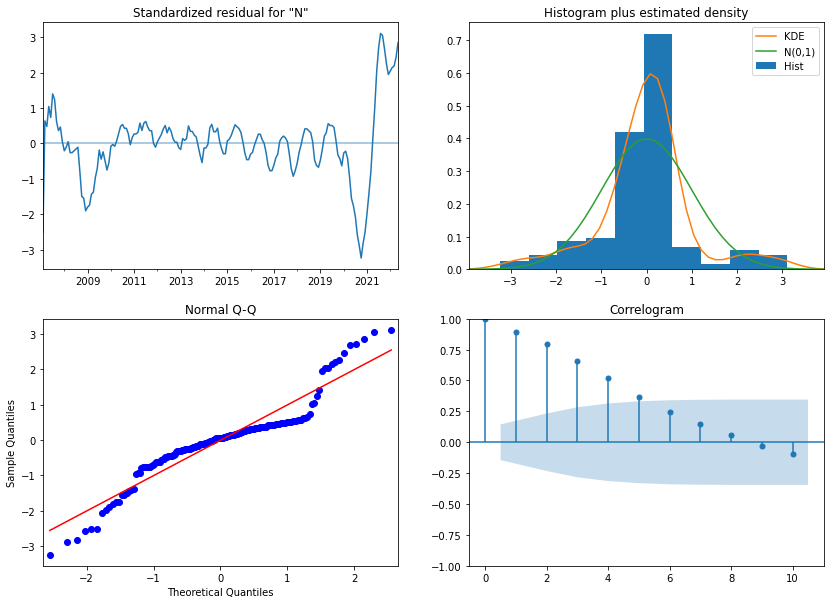

In [38]:
# Call plot_diagnostics() on the results calculated above 
baseline_mod.plot_diagnostics(figsize=(14, 10))
plt.show()

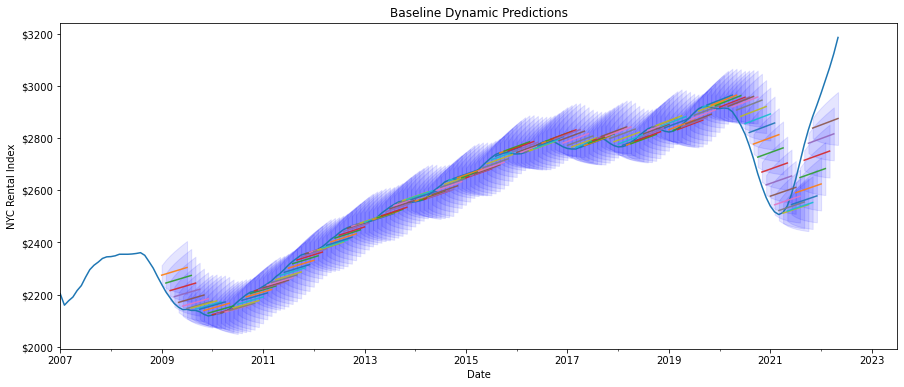

In [39]:
plot_forecast(baseline_mod, 'Baseline', conf=True, steps=6)

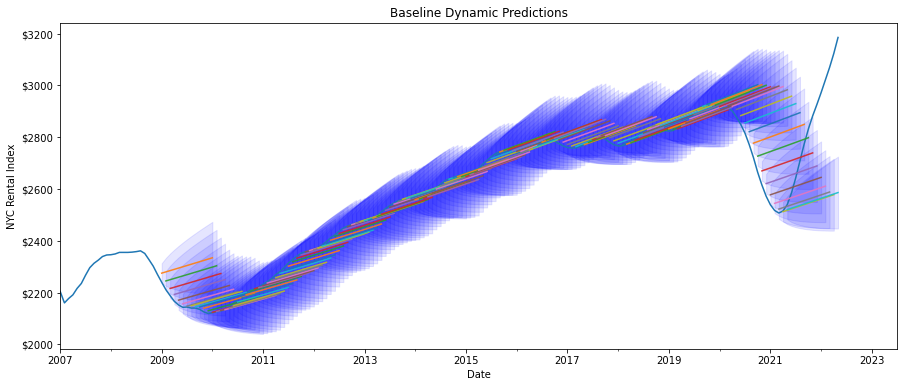

In [40]:
plot_forecast(baseline_mod, 'Baseline', conf=True, steps=12)

In [41]:
rmse, aic = prediction_error(baseline_mod, steps=6)
print('RMSE 6 Steps: ', rmse)
print('AIC 6 Steps: ', aic)
rmse, aic = prediction_error(baseline_mod, steps=12)
print('RMSE 12 Steps: ', rmse)
print('AIC 12 Steps: ', aic)

RMSE 6 Steps:  113.81116204817272
AIC 6 Steps:  1471.7075865158608
RMSE 12 Steps:  155.47448200034094
AIC 12 Steps:  1507.8515213478488


The baseline model's dynamic predictions project a steady 0.21%/month growth in rental prices following the last known value. While this closely matches the growth from March 2013-April 2019, it completely fails to predict the drop and rise in rental prices in the May 2019-May 2022 period and also fails to predict the recovery in rental prices in the February 2010-February 2013 period. Without the use of exogenous variables, this level of error for dynamic predictions is to be expected. Since dynamic predictions using a purely autoregressive model only take into account past values of the target series, we wouldn't expect it to successfully model events that are caused by exogenous factors such as the COVID epidemic.

## SARIMA Feature Selection

Next we determining the best performing SARIMA model by lowest AIC score.

In [42]:
# Generate combinations of SARIMA values

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q triplets with single differencing
pdq = [(x[0], 1, x[1]) for x in list(itertools.product(p, q))]

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [43]:
ans=[]
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(rental_data['NYC Rental Index'],
                                    order = comb,
                                    seasonal_order = combs,
                                    trend='c',
                                    enforce_stationarity=False,
                                    enforce_invertibility=False).fit(disp=False)
                
            prediction_errors_6 = prediction_error(mod, steps=6)
            prediction_errors_12 = prediction_error(mod, steps=12)
            ans.append([comb, combs, mod.aic]+list(prediction_errors_6)+list(prediction_errors_12))
        except:
            continue

In [44]:
ans_sarima_df = pd.DataFrame(ans, columns=['comb', 'combs', 'aic', 'rmse 6', 'aic 6', 'rmse 12', 'aic 12'])

In [45]:
# summary statistics for SARIMA model performance

ans_sarima_df.describe()

,aic,rmse 6,aic 6,rmse 12,aic 12
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,1232.306956,113.137372,1469.565726,209.242717,1591.962072
std,201.167630,20.579013,49.764897,49.473174,73.333732
min,978.965026,91.977064,1407.677165,141.924007,1482.676941
25%,1028.296222,101.523144,1440.401718,162.328974,1523.752486
50%,1224.945082,106.085723,1452.888624,218.081752,1612.689440
75%,1404.958106,116.153899,1482.974071,237.922665,1640.634005
max,1626.569107,172.191798,1600.068777,299.631414,1705.360824


Even though we're ultimately going to be more interested in our model's AIC score for six and 12 month predictions, I'm selecting the top model by its regular AIC score as a baseline for adding exogenous regressors. This is because dynamic predictions are not used in model fitting - if I were to select the best SARIMA features based six or twelve month AIC, I might be leaving out features that play an important role in modeling short term rental price movements even if they happen to result in less forecasting error over the longer term.

In [46]:
ans_sarima_df.sort_values(by='aic').head()

,comb,combs,aic,rmse 6,aic 6,rmse 12,aic 12
27,"(1, 1, 1)","(0, 1, 1, 12)",978.965026,101.120248,1441.056218,240.501837,1643.852863
31,"(1, 1, 1)","(1, 1, 1, 12)",982.264710,111.112796,1472.269217,263.700516,1673.294587
30,"(1, 1, 1)","(1, 1, 0, 12)",996.216870,108.188098,1462.000121,266.240411,1674.151111
29,"(1, 1, 1)","(1, 0, 1, 12)",1010.629879,94.095399,1420.735838,221.448442,1621.256558
25,"(1, 1, 1)","(0, 0, 1, 12)",1015.390969,95.288406,1422.641525,221.477765,1619.296016


In [47]:
best_sarima_mod_pred_aic = sm.tsa.statespace.SARIMAX(rental_data['NYC Rental Index'],
                                    order = (1, 1, 1),
                                    seasonal_order = (0, 1, 1, 12),
                                    trend='c',
                                    enforce_stationarity=False,
                                    enforce_invertibility=False).fit(disp=False)
best_sarima_mod_pred_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   NYC Rental Index   No. Observations:                  185
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -484.483
Date:                            Sun, 11 Sep 2022   AIC                            978.965
Time:                                    15:54:20   BIC                            994.278
Sample:                                01-01-2007   HQIC                           985.184
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2917      0.368      0.792      0.428      -0.430       1.013
ar.L1          0.9525      0.022     43.318      0.000       0.909       0.996
ma.L1          0.3709      0.069      5.401      0.000       0.236       0.506
ma.S.L12      -0.4695      0.054     -8.626      0.000      -0.576      -0.363
sigma2        26.8767      2.473     10.866      0.000      22.029      31.725
===================================================================================
Ljung-Box (L1) (Q):                   2.22   Jarque-Bera (JB):                40.34
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                             0.71
Prob(H) (two-sided):                  0.47   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

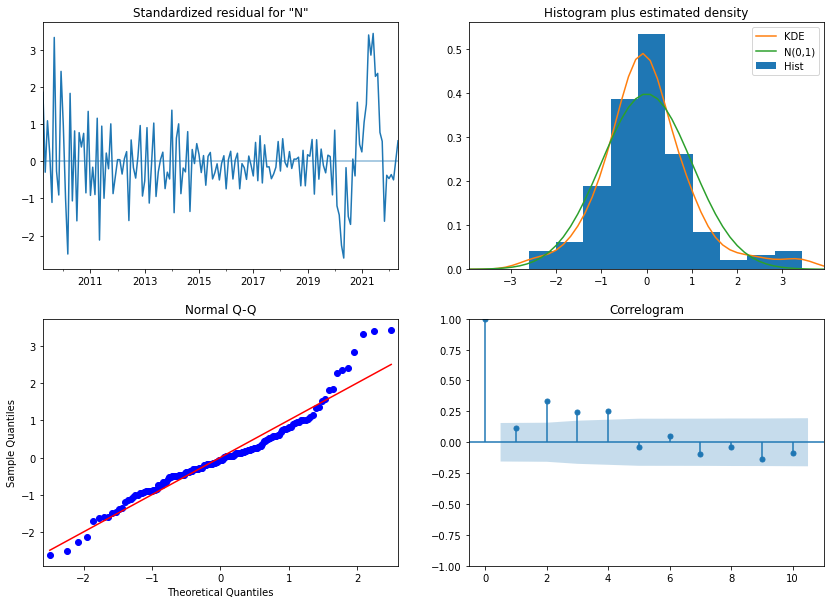

In [48]:
best_sarima_mod_pred_aic.plot_diagnostics(figsize=(14, 10))
plt.show()

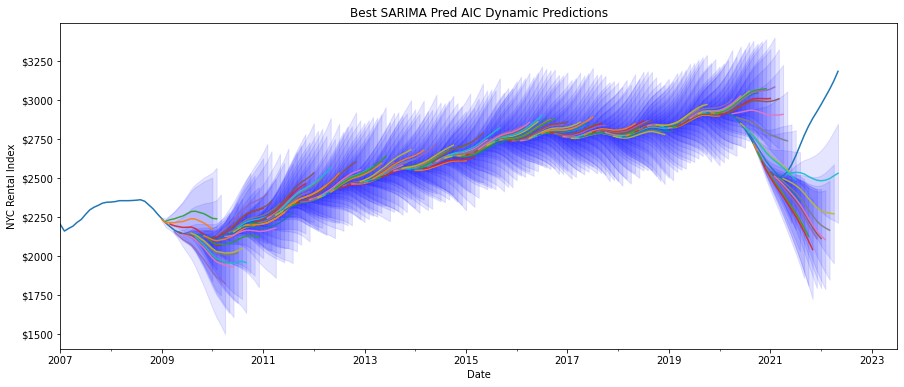

In [49]:
plot_forecast(best_sarima_mod_pred_aic, 'Best SARIMA Pred AIC', conf=True, steps=12)

## Best SARIMA Model by AIC

Below we see that adding additional MA terms to the model improved it--lowering the model's AIC score, reducing its kurtosis and heteroskedasticity, and decreasing the correlation of its residuals:

In [50]:
best_sarima_mod_aic = sm.tsa.statespace.SARIMAX(rental_data['NYC Rental Index'],
                                    order = (1, 1, 4),
                                    seasonal_order = (0, 1, 1, 12),
                                    enforce_stationarity=False,
                                    trend = 'c',
                                    enforce_invertibility=False).fit(disp=False)
best_sarima_mod_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     NYC Rental Index   No. Observations:                  185
Model:             SARIMAX(1, 1, 4)x(0, 1, [1], 12)   Log Likelihood                -439.942
Date:                              Sun, 11 Sep 2022   AIC                            895.884
Time:                                      15:54:22   BIC                            920.232
Sample:                                  01-01-2007   HQIC                           905.774
                                       - 05-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2030      0.189      1.076      0.282      -0.167       0.573
ar.L1          0.9351      0.045     20.835      0.000       0.847       1.023
ma.L1          0.3729      0.088      4.228      0.000       0.200       0.546
ma.L2          0.1958      0.085      2.310      0.021       0.030       0.362
ma.L3          0.3437      0.090      3.830      0.000       0.168       0.520
ma.L4          0.3416      0.094      3.637      0.000       0.158       0.526
ma.S.L12      -0.8713      0.098     -8.934      0.000      -1.062      -0.680
sigma2        16.0188      1.717      9.331      0.000      12.654      19.384
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                22.81
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.38
Prob(H) (two-sided):                  0.63   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

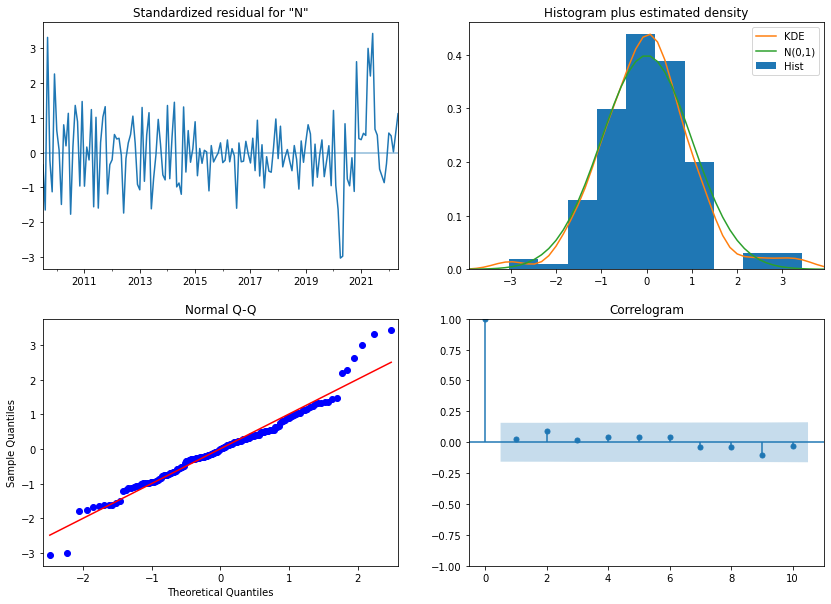

In [51]:
best_sarima_mod_aic.plot_diagnostics(figsize=(14, 10))
plt.show()

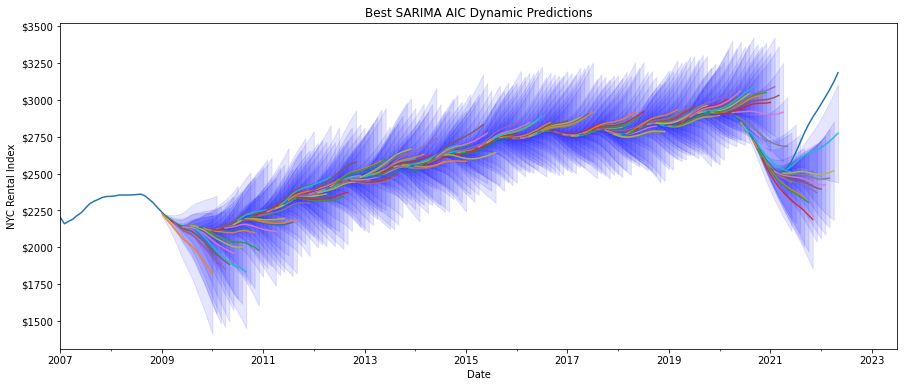

In [52]:
plot_forecast(best_sarima_mod_aic, 'Best SARIMA AIC', conf=True, steps=12, save=True)

### Forecast Errors

In [53]:
errors = prediction_error(best_sarima_mod_aic, steps=6)
print('6 Month RMSE: ', errors[0])
print('6 Month AIC: ', errors[1])

6 Month RMSE:  77.71265866551207
6 Month AIC:  1365.4356300005497


In [54]:
errors = prediction_error(best_sarima_mod_aic, steps=12)
print('12 Month RMSE: ', errors[0])
print('12 Month AIC: ', errors[1])

12 Month RMSE:  200.62915412911337
12 Month AIC:  1595.8345434836076


Impressively, the 6-month ahead error for this model is now only 77.7 down from 101.1, while the 12-month error is down to 201 from 240. Similarly AIC has been reduced from 1441 to 1365 for 6 month forecasts and from 1644 to 1596 for 12 months forecasts.

## SARIMAX Model Selection

In [64]:
ans = []

for exog in exog_combs[1:]:

    mod = sm.tsa.statespace.SARIMAX(rental_data['NYC Rental Index'],
                                exog=rental_data[exog],
                                order = (1, 1, 4),
                                seasonal_order = (0, 1, 1, 12),
                                trend='c',
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit(disp=False)
    prediction_errors_6 = prediction_error(mod, steps=6, exog=rental_data[exog])
    prediction_errors_12 = prediction_error(mod, steps=12, exog=rental_data[exog])
    ans.append([exog, mod.aic]+list(prediction_errors_6)+list(prediction_errors_12))

In [65]:
ans_sarimax_df = pd.DataFrame(ans, columns=['exog', 'aic', 'rmse 6', 'aic 6', 'rmse 12', 'aic 12'])

In [66]:
ans_sarimax_df.sort_values(by='aic').head()

,exog,aic,rmse 6,aic 6,rmse 12,aic 12
2,[Federal Funds Rate 4 Month Lag 1 Difference],896.034578,77.941290,1368.346314,200.356022,1597.428576
4,[Building Materials 14 Month Lag 1 Difference],897.727915,77.726844,1367.492213,200.983071,1598.359763
13,"[Federal Funds Rate 4 Month Lag 1 Difference, Building Materials 14 Month Lag 1 Difference]",897.816072,77.913551,1370.235968,200.579149,1599.760260
11,"[Manhattan Sale Price Index 16 Month Lag 1 Difference, Building Materials 14 Month Lag 1 Difference]",931.127859,83.812823,1392.861665,218.395783,1625.120063
1,[Manhattan Sale Price Index 16 Month Lag 1 Difference],950.543159,86.488703,1400.604280,236.935199,1647.400431


In [67]:
ans_sarimax_df.sort_values(by='aic 6').head()

,exog,aic,rmse 6,aic 6,rmse 12,aic 12
0,[Manhattan Sale Price Index 9 Month Lag 1 Difference],952.697274,76.803394,1363.787137,188.734074,1579.621025
4,[Building Materials 14 Month Lag 1 Difference],897.727915,77.726844,1367.492213,200.983071,1598.359763
2,[Federal Funds Rate 4 Month Lag 1 Difference],896.034578,77.941290,1368.346314,200.356022,1597.428576
13,"[Federal Funds Rate 4 Month Lag 1 Difference, Building Materials 14 Month Lag 1 Difference]",897.816072,77.913551,1370.235968,200.579149,1599.760260
8,"[Manhattan Sale Price Index 9 Month Lag 1 Difference, Building Materials 14 Month Lag 1 Difference]",953.977039,78.549644,1372.756560,194.721112,1590.927366


In [68]:
ans_sarimax_df.sort_values(by='aic 12').head()

,exog,aic,rmse 6,aic 6,rmse 12,aic 12
19,"[Manhattan Sale Price Index 9 Month Lag 1 Difference, Federal Funds Rate 4 Month Lag 1 Difference, Building Materials 14 Month Lag 1 Difference]",979.164756,82.222549,1388.923172,180.852167,1570.908621
0,[Manhattan Sale Price Index 9 Month Lag 1 Difference],952.697274,76.803394,1363.787137,188.734074,1579.621025
8,"[Manhattan Sale Price Index 9 Month Lag 1 Difference, Building Materials 14 Month Lag 1 Difference]",953.977039,78.549644,1372.756560,194.721112,1590.927366
9,"[Manhattan Sale Price Index 16 Month Lag 1 Difference, Federal Funds Rate 4 Month Lag 1 Difference]",951.865955,82.669831,1388.604968,196.737506,1593.997375
15,"[Manhattan Sale Price Index 9 Month Lag 1 Difference, Manhattan Sale Price Index 16 Month Lag 1 Difference, Federal Funds Rate 4 Month Lag 1 Difference]",991.204206,82.748868,1390.901204,196.768032,1596.043609


Our best SARIMA model has an AIC of 1365 for 6 month ahead forecasts and an AIC of 1596 for 12 month ahead forecasts. No SARIMAX models significantly improve on this low 6 month AIC score, while two models improve on the best 12 month AIC score. In the best case (Model 19), we see 12 month AIC improve by 25 points, corresponding to a 20 point improvement in RMSE. While these scores are actually worse than the 12 month RMSE and AIC for our baseline AR(1) model(AIC = 1508, RMSE=155), the AR(1) model's poor 1-step ahead performance and non-normal residuals make it far inferior to our current model's whose normally distributed residuals make them much more useful for predictions.

Below we examine the summary statistics for our best SARIMAX model to see if we can improve it by adding additional terms.

In [69]:
sarimax_mod_aic_12 = sm.tsa.statespace.SARIMAX(rental_data['NYC Rental Index'],
                                        exog=rental_data[['Manhattan Sale Price Index 9 Month Lag 1 Difference', 'Federal Funds Rate 4 Month Lag 1 Difference', 'Building Materials 14 Month Lag 1 Difference']],
                                        order = (1, 1, 4),
                                        seasonal_order = (0, 1, 1, 12),
                                        trend = 'c',
                                        enforce_stationarity=False,
                                        enforce_invertibility=False).fit(disp=False)
sarimax_mod_aic_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     NYC Rental Index   No. Observations:                  185
Model:             SARIMAX(1, 1, 4)x(0, 1, [1], 12)   Log Likelihood                -478.582
Date:                              Sun, 11 Sep 2022   AIC                            979.165
Time:                                      16:10:52   BIC                           1012.642
Sample:                                  01-01-2007   HQIC                           992.763
                                       - 05-01-2022                                         
Covariance Type:                                opg                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
intercept                                               0.4138      1.014      0.408      0.683      -1.574       2.402
Manhattan Sale Price Index 9 Month Lag 1 Difference  8.294e-06      0.000      0.030      0.976      -0.001       0.001
Federal Funds Rate 4 Month Lag 1 Difference           -30.4028      8.509     -3.573      0.000     -47.081     -13.725
Building Materials 14 Month Lag 1 Difference            0.0089      0.359      0.025      0.980      -0.695       0.712
ar.L1                                                   0.7753      0.138      5.614      0.000       0.505       1.046
ma.L1                                                   0.6289      0.166      3.787      0.000       0.303       0.954
ma.L2                                                   0.5157      0.167      3.084      0.002       0.188       0.843
ma.L3                                                   0.5278      0.182      2.902      0.004       0.171       0.884
ma.L4                                                   0.5138      0.128      3.998      0.000       0.262       0.766
ma.S.L12                                               -0.7266      0.174     -4.167      0.000      -1.068      -0.385
sigma2                                                 46.5803      8.660      5.379      0.000      29.607      63.554
===================================================================================
Ljung-Box (L1) (Q):                   2.29   Jarque-Bera (JB):                27.18
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.30
Prob(H) (two-sided):                  0.22   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

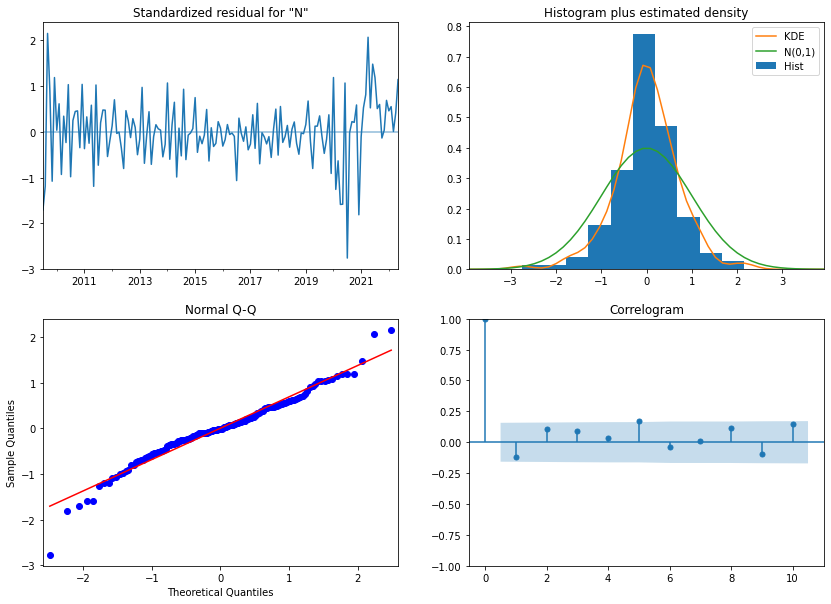

In [70]:
sarimax_mod_aic_12.plot_diagnostics(figsize=(14, 10))
plt.show()

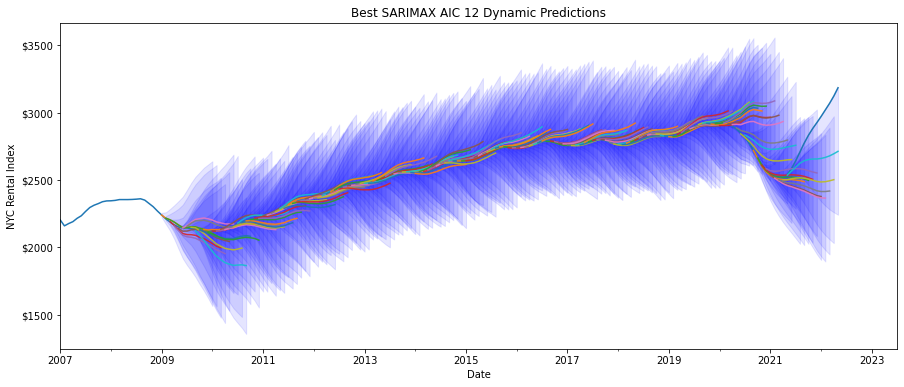

In [71]:
plot_forecast(sarimax_mod_aic_12, 'Best SARIMAX AIC 12', exog=rental_data[['Manhattan Sale Price Index 9 Month Lag 1 Difference', 'Federal Funds Rate 4 Month Lag 1 Difference', 'Building Materials 14 Month Lag 1 Difference']], dynamic=True, steps=12, conf=True)

The main problem with this model are the outsized residuals that we see during the 2020-2021 period. As we see below, the addition of an extra MA term evens out the residuals, reducing the JB score as well as the model's heteroskedasticity and kurtosis.

In [72]:
sarimax_mod_aic_12 = sm.tsa.statespace.SARIMAX(rental_data['NYC Rental Index'],
                                        exog=rental_data[['Manhattan Sale Price Index 9 Month Lag 1 Difference', 'Federal Funds Rate 4 Month Lag 1 Difference', 'Building Materials 14 Month Lag 1 Difference']],
                                        order = (1, 1, 5),
                                        seasonal_order = (0, 1, 1, 12),
                                        trend = 'c',
                                        enforce_stationarity=False,
                                        enforce_invertibility=False).fit(disp=False)
sarimax_mod_aic_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     NYC Rental Index   No. Observations:                  185
Model:             SARIMAX(1, 1, 5)x(0, 1, [1], 12)   Log Likelihood                -468.572
Date:                              Sun, 11 Sep 2022   AIC                            961.145
Time:                                      16:10:55   BIC                            997.588
Sample:                                  01-01-2007   HQIC                           975.948
                                       - 05-01-2022                                         
Covariance Type:                                opg                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
intercept                                               0.4521      0.912      0.496      0.620      -1.336       2.240
Manhattan Sale Price Index 9 Month Lag 1 Difference  9.156e-05      0.000      0.378      0.705      -0.000       0.001
Federal Funds Rate 4 Month Lag 1 Difference           -30.3939      7.315     -4.155      0.000     -44.731     -16.057
Building Materials 14 Month Lag 1 Difference           -0.2970      0.326     -0.910      0.363      -0.937       0.343
ar.L1                                                   0.8214      0.154      5.325      0.000       0.519       1.124
ma.L1                                                   0.5170      0.163      3.172      0.002       0.197       0.836
ma.L2                                                   0.5315      0.179      2.974      0.003       0.181       0.882
ma.L3                                                   0.6409      0.132      4.850      0.000       0.382       0.900
ma.L4                                                   0.6471      0.175      3.691      0.000       0.304       0.991
ma.L5                                                   0.2659      0.181      1.470      0.141      -0.089       0.620
ma.S.L12                                               -0.7774      0.174     -4.477      0.000      -1.118      -0.437
sigma2                                                 39.9843      7.528      5.312      0.000      25.231      54.738
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                 2.26
Prob(Q):                              0.33   Prob(JB):                         0.32
Heteroskedasticity (H):               1.07   Skew:                             0.03
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

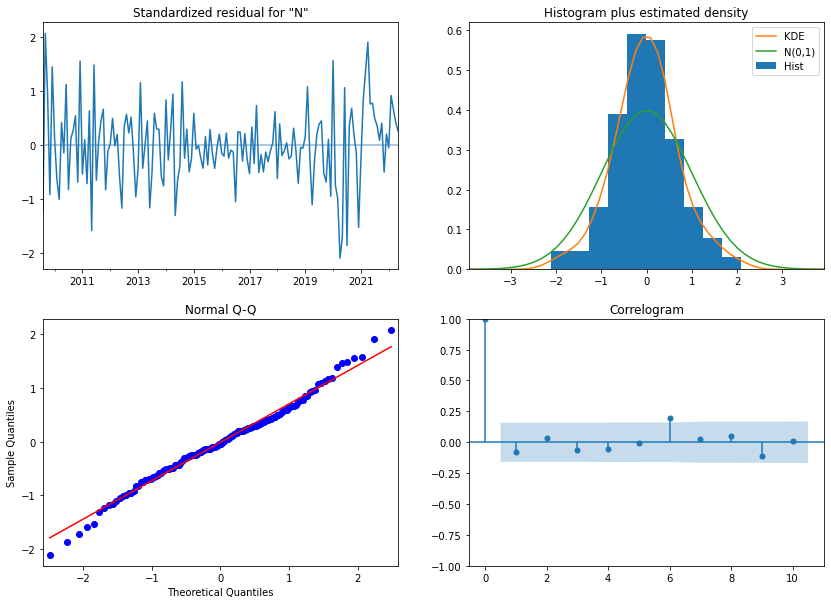

In [73]:
sarimax_mod_aic_12.plot_diagnostics(figsize=(14, 10))
plt.show()

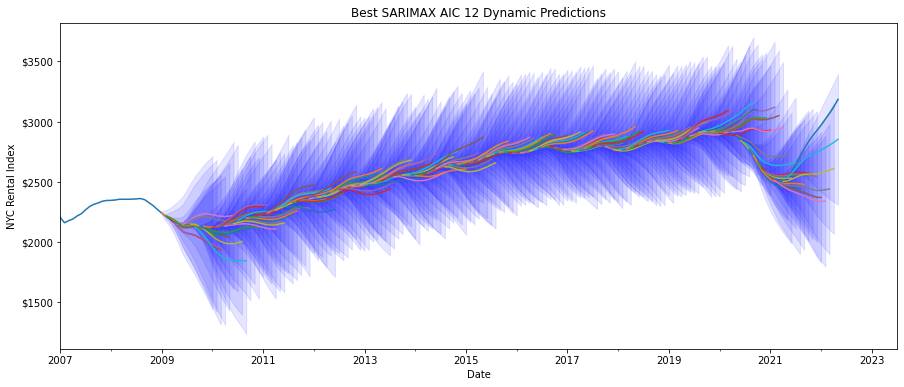

In [74]:
plot_forecast(sarimax_mod_aic_12, 'Best SARIMAX AIC 12', exog=rental_data[['Manhattan Sale Price Index 9 Month Lag 1 Difference', 'Federal Funds Rate 4 Month Lag 1 Difference', 'Building Materials 14 Month Lag 1 Difference']], dynamic=True, steps=12, conf=True, save=True)

Below we can see that making these tweaks to our model actually raised the 6 month AIC and 12 month AIC. However, the 12 month ahead AIC is still 15 points below that of the best SARIMA model, indicating that it is better than the best SARIMA model for making 12 month ahead predictions. Most importantly, the skew and heteroskedasticity of this model are smaller than that of the best SARIMA model, which tells us that the inclusion of the three exogenous regressors has successful eliminated of some of the original model's bias, even as the overal level of error remains fairly large.

Overall, these metrics suggest a significant improvement over simple SARIMA modeling, even though our new model doesn't have much effect on overall error.

In [75]:
prediction_error(sarimax_mod_aic_12, steps=6, exog=rental_data[['Manhattan Sale Price Index 9 Month Lag 1 Difference', 'Federal Funds Rate 4 Month Lag 1 Difference', 'Building Materials 14 Month Lag 1 Difference']])

(81.4900353228233, 1388.1490315061694)

In [76]:
prediction_error(sarimax_mod_aic_12, steps=12, exog=rental_data[['Manhattan Sale Price Index 9 Month Lag 1 Difference', 'Federal Funds Rate 4 Month Lag 1 Difference', 'Building Materials 14 Month Lag 1 Difference']])

(185.3825826141037, 1580.281667735651)

### Residuals: SARIMA vs. SARIMAX

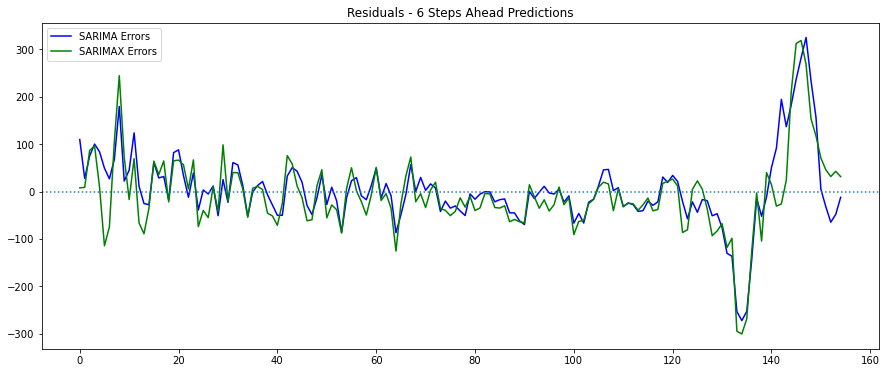

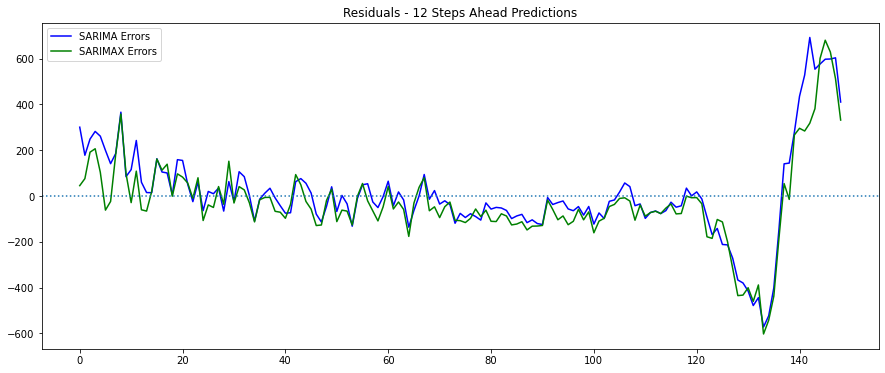

In [82]:
for steps in [6, 12]:
#calculating sarima errors
    sarima_errors = np.zeros(len(rental_data.index[24:-steps]))
    for i in range(len(rental_data.index[24:-steps])):
        
        start = rental_data.index[i+24]
        end = rental_data.index[i+24+steps]
            
        y_pred = best_sarima_mod_aic.predict(start=start, end=end, exog=None, dynamic=True)[-1]
        y_val = rental_data['NYC Rental Index'][end]
        sarima_errors[i] += y_val-y_pred    
#calculating sarimax errors    
    sarimax_errors = np.zeros(len(rental_data.index[24:-steps]))
    for i in range(len(rental_data.index[24:-steps])):
        
        start = rental_data.index[i+24]
        end = rental_data.index[i+24+steps]
            
        y_pred = sarimax_mod_aic_12.predict(start=start, end=end, exog=rental_data[['Manhattan Sale Price Index 9 Month Lag 1 Difference', 'Federal Funds Rate 4 Month Lag 1 Difference', 'Building Materials 14 Month Lag 1 Difference']], dynamic=True)[-1]
        y_val = rental_data['NYC Rental Index'][end]
        sarimax_errors[i] += y_val-y_pred
            
    fig, ax = plt.subplots()
    ax.plot(sarima_errors, color='b', label='SARIMA Errors')
    ax.plot(sarimax_errors, color='g', label='SARIMAX Errors')
    ax.axhline(0, ls=':')
    ax.set_title(f'Residuals - {steps} Steps Ahead Predictions')
    ax.legend()
    plt.show()

Above we see the specific improvements of our SARIMAX model in comparison with our SARIMA model. The SARIMAX model's forecasting errors are improved both for the beginning and the end of the data set, but the improvement at the beginning of the data set is much more significant. For the first few predictions the SARIMAX model's errors are distributed evenly around 0, whereas the SARIMA model's errors were consistently positive. The improvement for the COVID period is much smaller, though we can still see how the model is an improvement.

# Evaluating our SARIMAX Model

Because we didn't use a holdout dataset for validating our model, we can only judge it in comparison to the best SARIMA model. While this best SARIMA model had a lower AIC score (895 compared with 961), this model improved the 12 month AIC by 25 points, which indicates that it is significantly better in its forecasting than the simple SARIMA model. It's residuals are also more normally distributed, with a lowered skew (0.03) and kurtosis (3.59) compared with the SARIMA model which had a skew of 0.38 and a kurtosis of 4.72. The heteroskedasticity was also marginally decreased from 1.14 to 1.07.

All of this indicates that the exogenous variables are doing a good job modeling some of the variability in the data. This seems to be especially true from 2011-2015, when the 12 month ahead forecasts are evenly spread above and below the series' true values. After this date, however, 12 months forecasts tend to be either above true rental values (through 2020) or below true values (from 2021 to the present). This indicates that even though AIC has been reduced for 12 month ahead forecasts, there is still systemic error not being modeled by our current set of predictors.

Ultimately, we can see from looking at the coefficients for our exogenous regressors, that they are doing a fairly small amount of work to improve our model's predictions. Coefficients for Manhattan Sale Price and Building Materials are close to zero and have high p-values. The coefficient for Federal Funds Rate is statistically significant but its effect is small: A 1% increase in the month-to-month interest rate increases is correlated with only a $30 decrease in rental price increases. In other words, Interest rate increases are likely to slow the increase in rental prices, but not by a significant amount-since interest rates are generally raised by similarly sized amounts, rather than by steadily increasing increments.

## Using Our Model for Forecasting

Despite our model's weak predictive capacity, we can still use it to generate forecasts and prediction intervals that take into account the model's expected error. 

Because Manahttan Sale Price Index and the Federal Funds Rate are only included at a 4 month lag, we'll have to extrapolate values for these variables in order to use them to make predictions through July, 2023. We'll extrapolate two sets of values for these variables: values that minimize the model's predictions and models that maximize the model's predictions. We'll then plot both of these scenarios below.

In [68]:
# filling NA values for minimum rent increase scenario

lower_copy = all_data.copy()


max_fed_diff = lower_copy['Federal Funds Rate 4 Month Lag 1 Difference'].dropna().tail(12).max()
min_sale_price_diff = lower_copy['Manhattan Sale Price Index 9 Month Lag 1 Difference'].dropna().tail(12).min()

lower_copy['Federal Funds Rate 4 Month Lag 1 Difference'].fillna(max_fed_diff, inplace=True)

lower_copy['Manhattan Sale Price Index 9 Month Lag 1 Difference'].fillna(min_sale_price_diff, inplace=True) 

In [69]:
# filling NA values for maximum rent increase scenario

upper_copy = all_data.copy()


min_fed_diff = lower_copy['Federal Funds Rate 4 Month Lag 1 Difference'].dropna().tail(12).min()
max_sale_price_diff = lower_copy['Manhattan Sale Price Index 9 Month Lag 1 Difference'].dropna().tail(12).max()

upper_copy['Federal Funds Rate 4 Month Lag 1 Difference'].fillna(min_fed_diff, inplace=True)

upper_copy['Manhattan Sale Price Index 9 Month Lag 1 Difference'].fillna(max_sale_price_diff, inplace=True) 

Below we see the forecasts made by our trained model through June 2023, including the upper and lowest bounds of the model's 95% confidence interval.

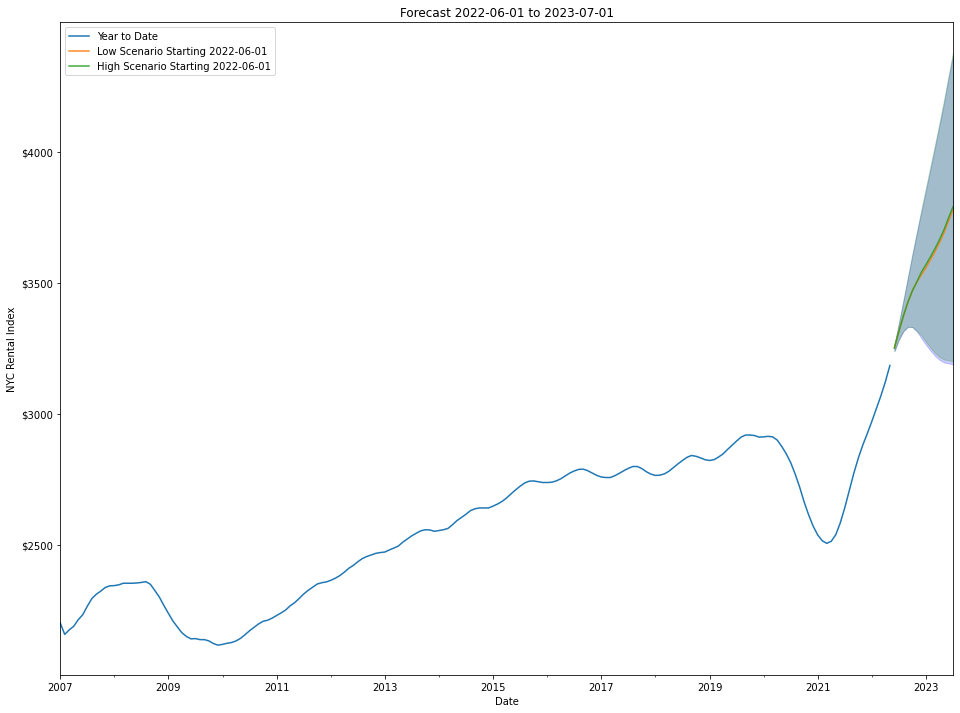

In [70]:
start_date = '2022-06-01'
end_date = '2023-07-01'

fig, ax = plt.subplots(figsize=(16, 12))
# Plot observed values
ax = all_data['NYC Rental Index']['2007-01-01':].plot(label='Year to Date')

#prediction for no interest rate increases
lower_pred = sarimax_mod_aic_12.get_prediction(start=start_date,
                          end=end_date,
                          exog=lower_copy[['Manhattan Sale Price Index 9 Month Lag 1 Difference', 'Federal Funds Rate 4 Month Lag 1 Difference', 'Building Materials 14 Month Lag 1 Difference']][start_date:end_date],
                          dynamic=True)
lower_pred_conf = lower_pred.conf_int()
    
# Plot predicted values
lower_pred.predicted_mean.plot(ax=ax, alpha=0.9, label=f'Low Scenario Starting {str(start_date)[:10]}')

# Plot the range for confidence intervals
ax.fill_between(lower_pred_conf.index,
                lower_pred_conf.iloc[:, 0],
                lower_pred_conf.iloc[:, 1], color='b', alpha=0.2)

# prediction for continued interest rate increases.

upper_pred = sarimax_mod_aic_12.get_prediction(start=start_date,
                          end=end_date,
                          exog=upper_copy[['Manhattan Sale Price Index 9 Month Lag 1 Difference', 'Federal Funds Rate 4 Month Lag 1 Difference', 'Building Materials 14 Month Lag 1 Difference']][start_date:end_date],
                          dynamic=True)
upper_pred_conf = upper_pred.conf_int()
    
# Plot predicted values
upper_pred.predicted_mean.plot(ax=ax, alpha=0.9, label=f'High Scenario Starting {str(start_date)[:10]}')

# Plot the range for confidence intervals
ax.fill_between(upper_pred_conf.index,
                upper_pred_conf.iloc[:, 0],
                upper_pred_conf.iloc[:, 1], color='g', alpha=0.2)


# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('NYC Rental Index')
ax.set_title(f'Forecast {start_date} to {end_date}')

formatter = ticker.FormatStrFormatter('$%1.0f')
ax.yaxis.set_major_formatter(formatter)

plt.legend(loc='upper left')

plt.savefig('images/forecast.png')
plt.show()

As we can see from the forecast above, the low and and high scenarios aren't drastically different, showing that changes in interest rates and Manhattan Sale Prices don't play a huge role in our model's predictions. Essentially all our model tell us is that it's highly unlikely that median rents will rise above 4300 per month or fall below 3100 per month betwen now and July of 2022. While these are definitely not earth-shattering conclusions, this wide prediction interval makes sense given the fact that unpredictable exogenous shocks have often had major effects on the rental market. 

In [71]:
lower_forecast = pd.DataFrame([lower_pred.predicted_mean, lower_pred.conf_int().iloc[:,0], lower_pred.conf_int().iloc[:,1]]).T
lower_forecast

,predicted_mean,lower NYC Rental Index,upper NYC Rental Index
2022-06-01,3252.022405,3239.625909,3264.418901
2022-07-01,3314.731720,3283.204405,3346.259035
2022-08-01,3374.132373,3315.694069,3432.570676
2022-09-01,3426.660682,3332.562951,3520.758414
2022-10-01,3470.331358,3331.604880,3609.057836
2022-11-01,3504.368753,3315.354995,3693.382512
2022-12-01,3530.231640,3288.868482,3771.594799
2023-01-01,3558.311646,3264.270258,3852.353034
2023-02-01,3588.070571,3241.947285,3934.193857
2023-03-01,3619.012164,3221.919277,4016.105052


In [72]:
upper_forecast = pd.DataFrame([upper_pred.predicted_mean, upper_pred.conf_int().iloc[:,0], upper_pred.conf_int().iloc[:,1]]).T
upper_forecast

,predicted_mean,lower NYC Rental Index,upper NYC Rental Index
2022-06-01,3252.022405,3239.625909,3264.418901
2022-07-01,3314.731720,3283.204405,3346.259035
2022-08-01,3374.132373,3315.694069,3432.570676
2022-09-01,3426.660682,3332.562951,3520.758414
2022-10-01,3470.331358,3331.604880,3609.057836
2022-11-01,3504.368753,3315.354995,3693.382512
2022-12-01,3541.376082,3300.012924,3782.739241
2023-01-01,3569.456088,3275.414700,3863.497475
2023-02-01,3599.215013,3253.091727,3945.338299
2023-03-01,3630.439989,3233.347101,4027.532877


In [73]:
upper_forecast.loc['2023-07-01']/upper_forecast.loc['2022-07-01']

predicted_mean            1.143417
lower NYC Rental Index    0.974846
upper NYC Rental Index    1.308811
dtype: float64

In [74]:
lower_forecast.loc['2023-07-01']/lower_forecast.loc['2022-07-01']

predicted_mean            1.139969
lower NYC Rental Index    0.971365
upper NYC Rental Index    1.305396
dtype: float64

## Predictions

Our model predicts that by July 2023, NYC rents will be between 3779 and 3790 per month, representing a year over year increase of 14%. The model gives 2.5% probability that rents will fall by 3% or more as well as 2.5% probability that they will rise by over 30%. In other words, it's both unlikely that rents will fall and also unlikely that increases will match the 25% increase that we saw since last year.

## Recommendation and Caveats

Based on this model's forecasts, it's definitely recommended that renters lock in new leases sooner rather than later. If renters can get a two year lease, it's only worth doing so if rents are below 14% of what they would be paying for a 1 year lease, since that's the rate at which rents are expected to increase per the next year. 

One problem with our model is that it doesn't at all incorporate factors of supply and demand. Given the slow rises in wages relative to inflation, it's highly unlikely that demand will support the extreme price increases associated with the model's 97.5% prediction interval. While our EDA showed that wages and salaries were correlated with rents, this variable didn't add enough information to our SARIMA model's predictions for us to confidently include it as a predictor. 

The fact that we were not able to incorporate a simple measure of demand into our model points to a fundamental limitation of economic time series modeling. Even when relationships between variables are intuitively likely, economic time series models will often contain too few data points for us to validate those relationships statistically. While the engineering of new features for our model might allow us to include some of the factors that our current model left out, it's also possible that the irreducible uncertainty of the market may present a hard limit on the amount of error that we're able to eliminate by adding new variables.

